<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
!pip install -r /kaggle/input/requirements/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 922.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.1/918.1 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.2 MB/s eta 0:00:00:00:01
     ━

In [2]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

In [3]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.datasets import TSDataset
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, MAPE, MSE, SMAPE
from etna.models import (CatBoostModelPerSegment, CatBoostMultiSegmentModel,
                         LinearPerSegmentModel, MovingAverageModel, NaiveModel,
                         ProphetModel, SeasonalMovingAverageModel)
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform, PredictionIntervalOutliersTransform,
                             DensityOutliersTransform)

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set()

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [5]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /kaggle/working/atm_daily_cash.csv
26.1kB [00:00, 25.3MB/s]                   


'atm_daily_cash.csv'

In [6]:
df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Взглянем на то, что представляют из себя данные:

In [7]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [8]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

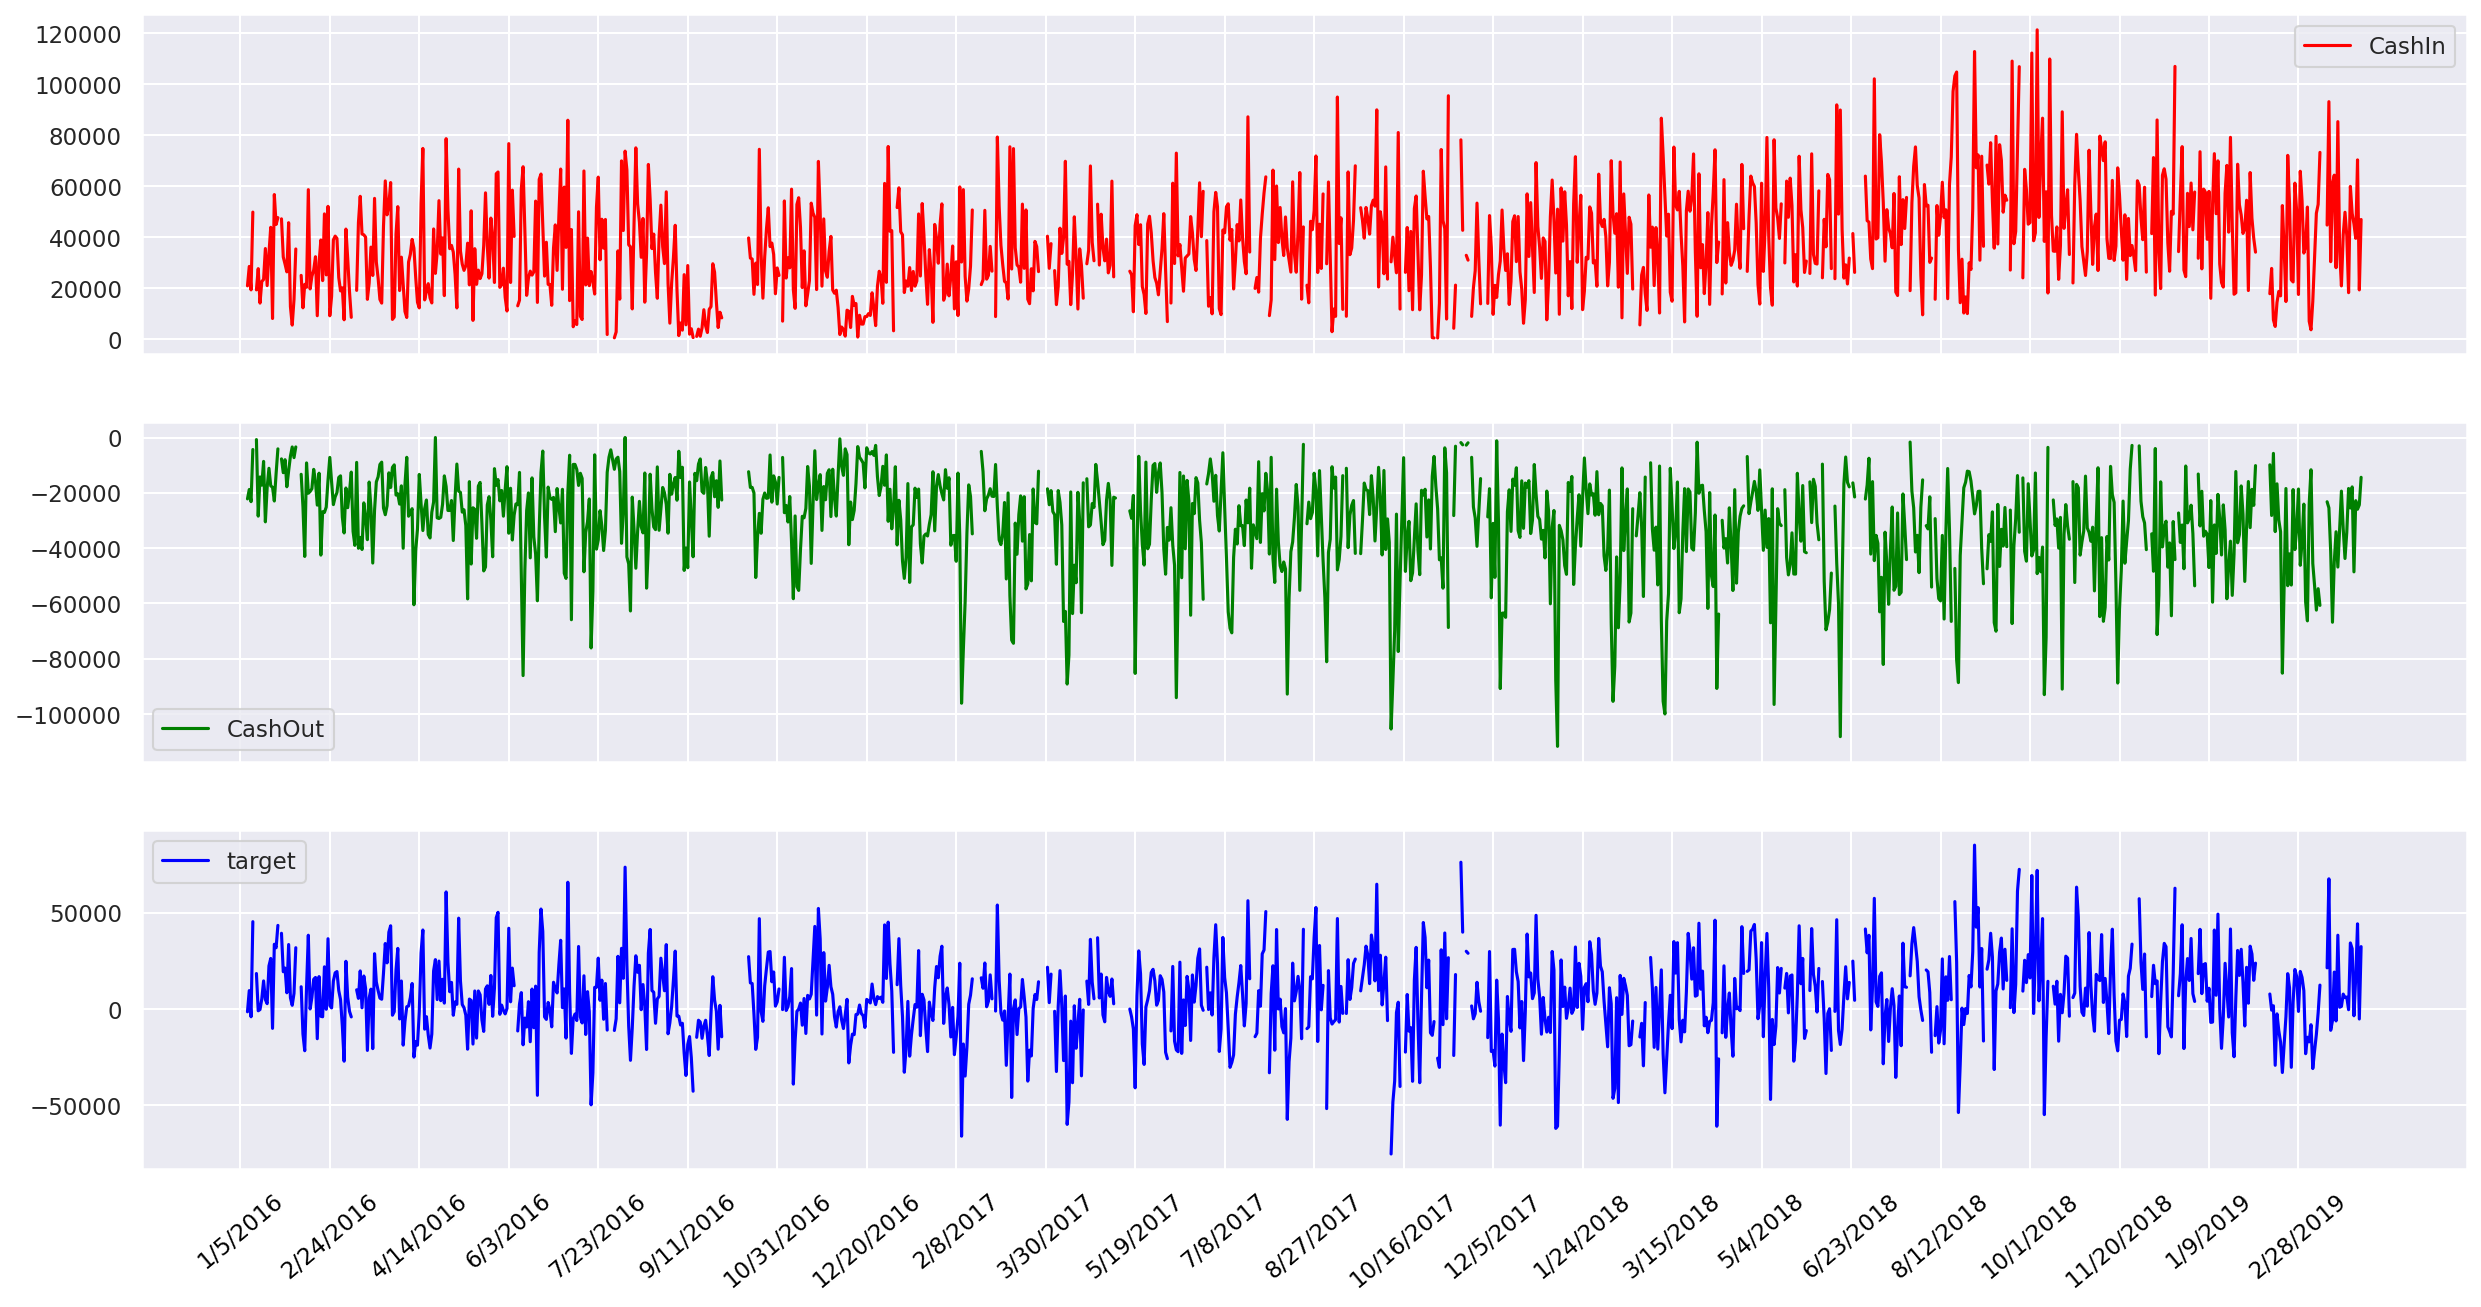

In [9]:
fig, axs = plt.subplots(3, sharex=True, figsize=(20, 10))
plt.xticks(range(0, df.shape[0], 50), [df.iloc[i][0] for i in range(0, df.shape[0], 50)], color='black', rotation=40)
for i, label in enumerate([['CashIn', 'red'], ['CashOut', 'green'], ['target', 'blue']]):
    axs[i].plot(df[label[0]], label=label[0], color=label[1])
    axs[i].legend()

В CashOut видно, что есть сильные периодические провалы - это говорит о том, что наблюдается определенная сезонность в снятии наличных. В CashIn аналогично, но чуть менее заметно. Таргет является линейной комбинации CashIn и CashOut, что и видно по пикам и провалам.

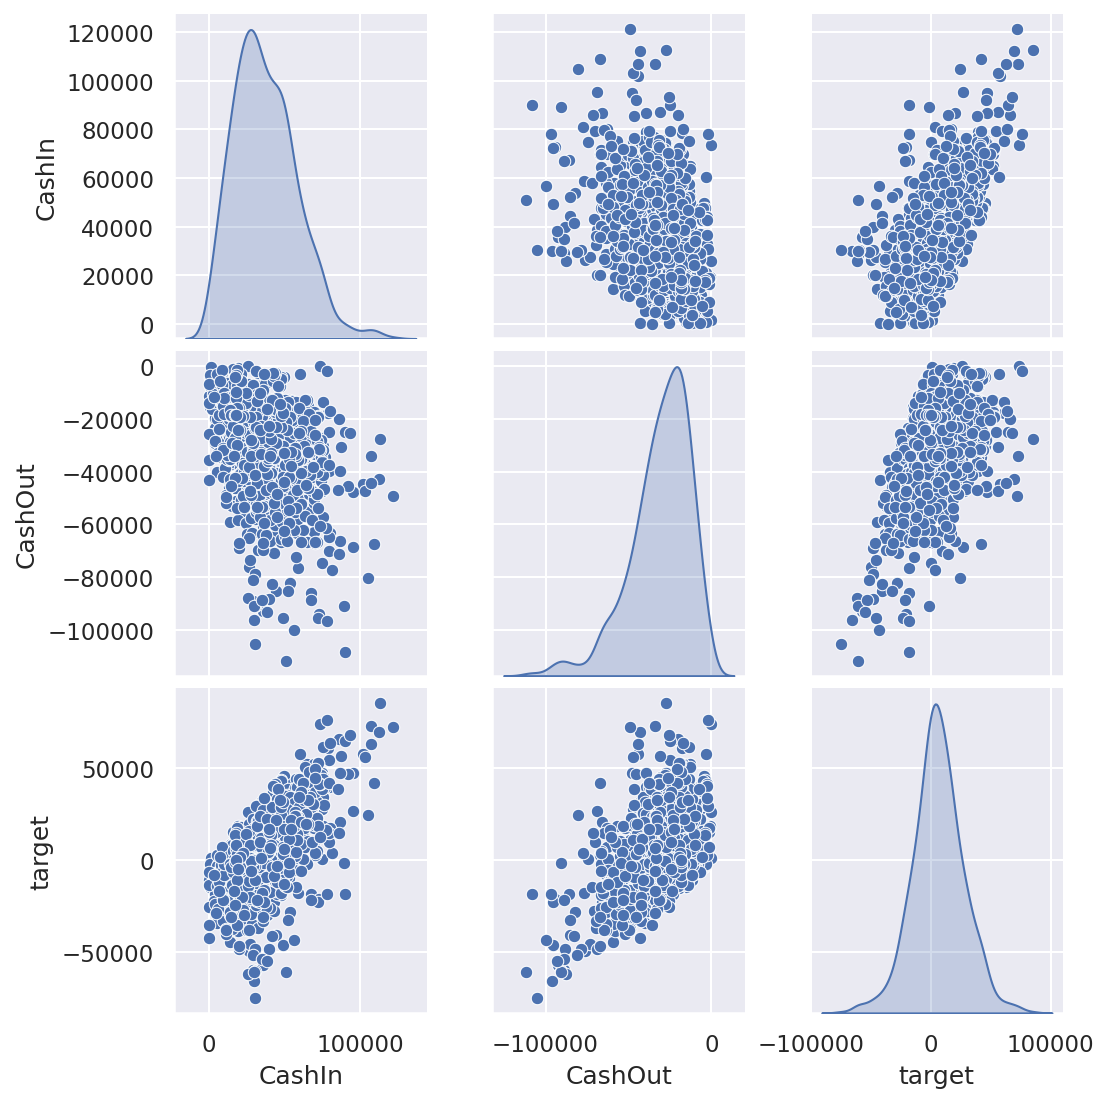

In [10]:
sns.pairplot(df, diag_kind="kde");

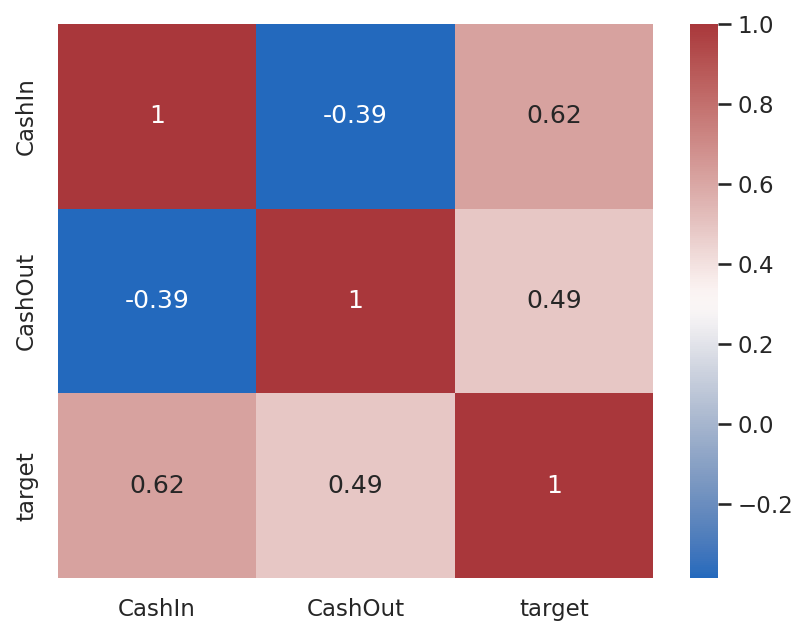

In [11]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

Видна корреляция таргета с обоими признаками(еще бы). Да и в целом как будто очевидно, что есть зависимость между тем, когда больше снимают и меньше кладут(и наоборот), что мы и видим по корреляциям.

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [12]:
from etna.datasets import TSDataset

In [13]:
dfcopy = pd.melt(df.copy(deep=True), id_vars=['Date'], value_vars=['target', 'CashIn', 'CashOut'], var_name='segment', value_name='target')
dfcopy.rename(columns={"Date": "timestamp"}, inplace=True)

In [14]:
dfcopy = TSDataset.to_dataset(dfcopy)
ts = TSDataset(dfcopy, freq="D")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [15]:
HORIZON=5

In [16]:
from etna.analysis import plot_imputation
from etna.transforms import TimeSeriesImputerTransform

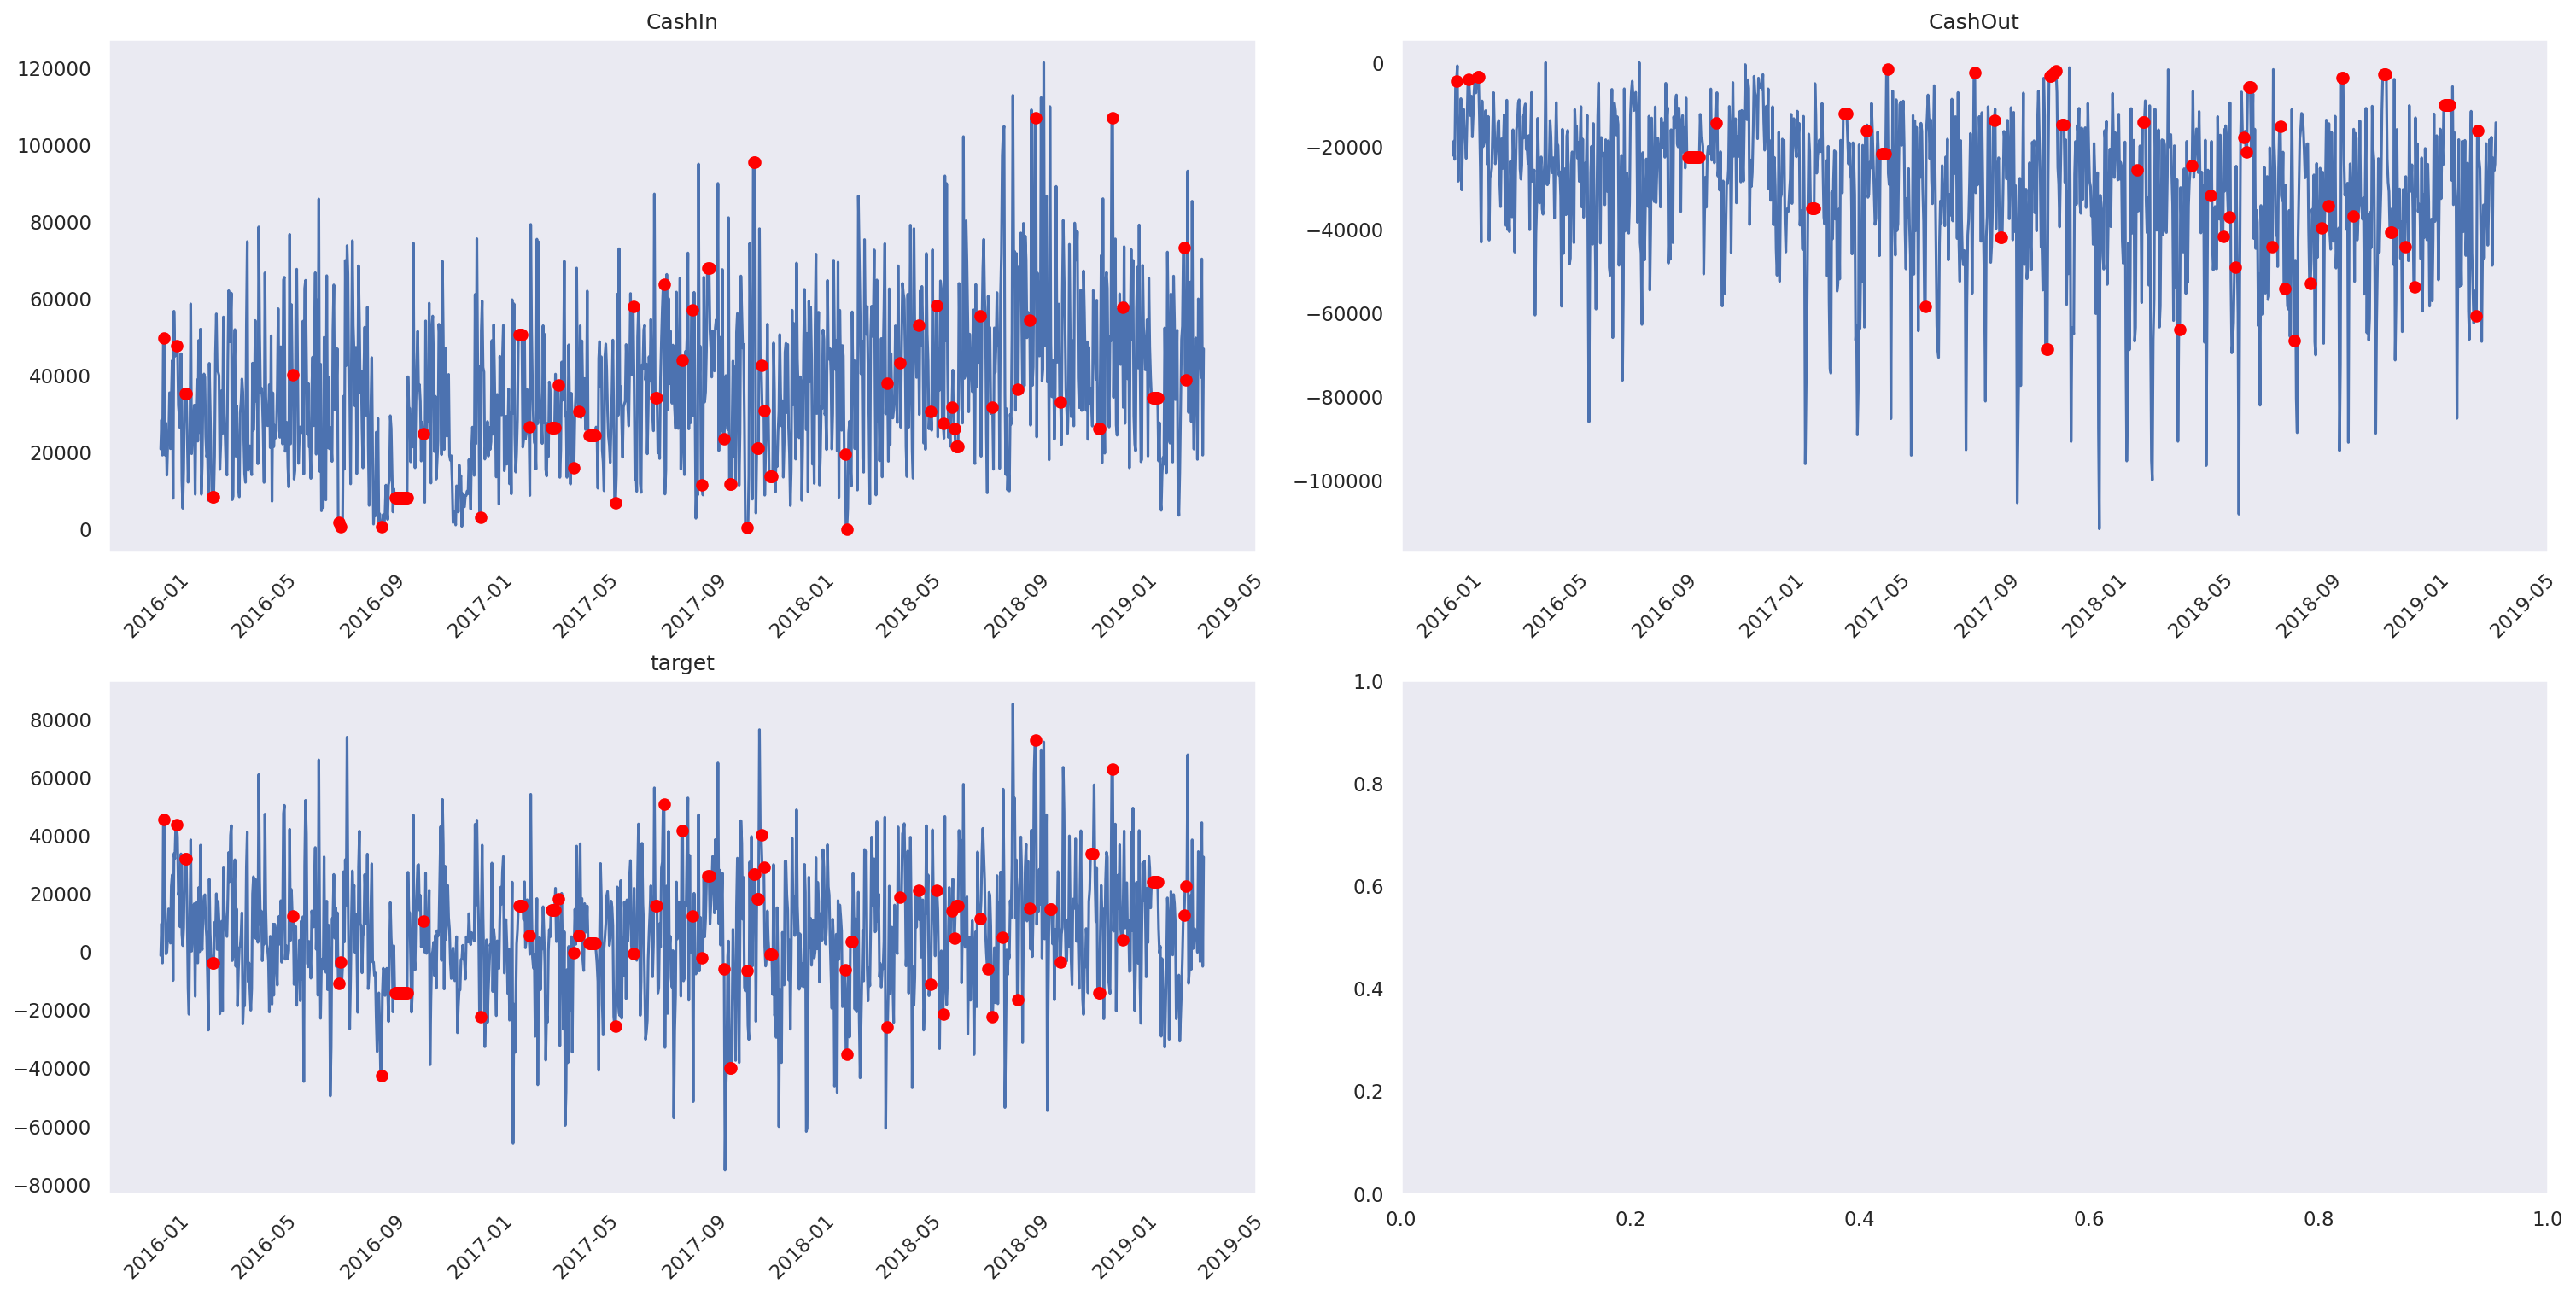

In [17]:
imputer_1 = TimeSeriesImputerTransform(in_column='target', strategy="forward_fill")
imputer_2 = TimeSeriesImputerTransform(in_column='CashIn', strategy="forward_fill")
imputer_3 = TimeSeriesImputerTransform(in_column='CashOut', strategy="forward_fill")
plot_imputation(ts=ts, imputer=imputer_1, segments=ts.segments)

In [18]:
ts.fit_transform([imputer_1])

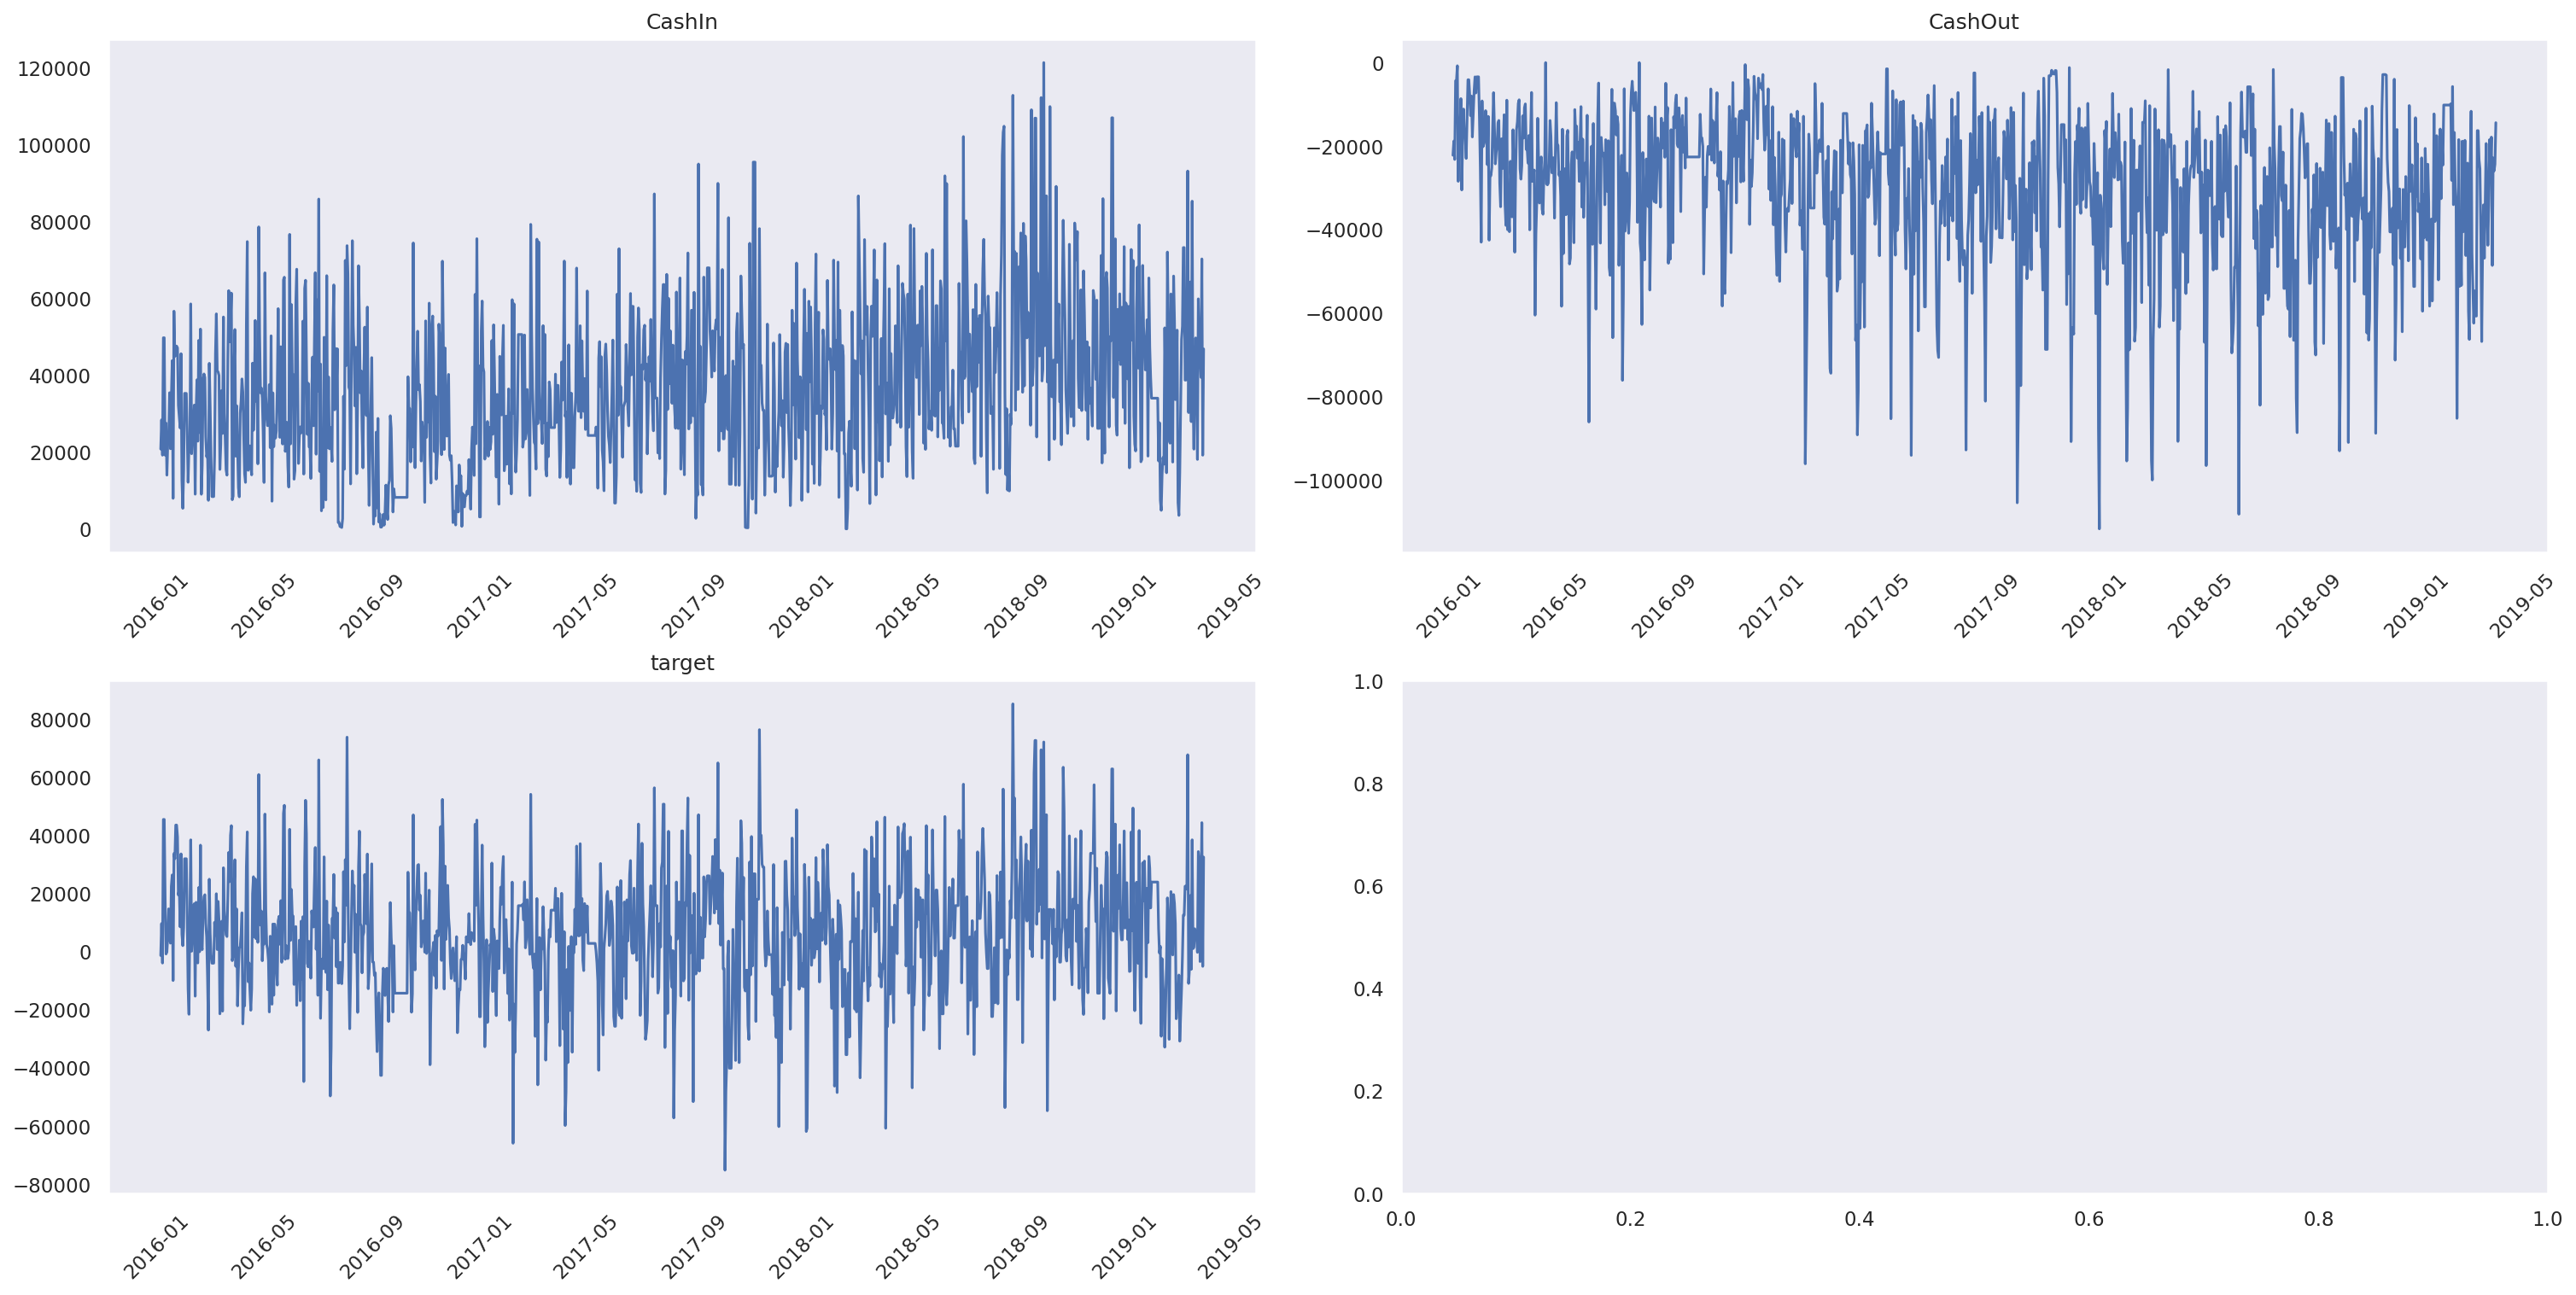

In [19]:
imputer = TimeSeriesImputerTransform(in_column='target', strategy="forward_fill")
plot_imputation(ts=ts, imputer=imputer_1, segments=ts.segments)

Ну, выбрал что-то простое, так как пропуски находятся между какими-то более-менее непрерывными кусками без пропусков, так что просто статистически заполнить их чем-то близким, кажется нормальным решением. 

In [20]:
from etna.analysis import sample_acf_plot, sample_pacf_plot

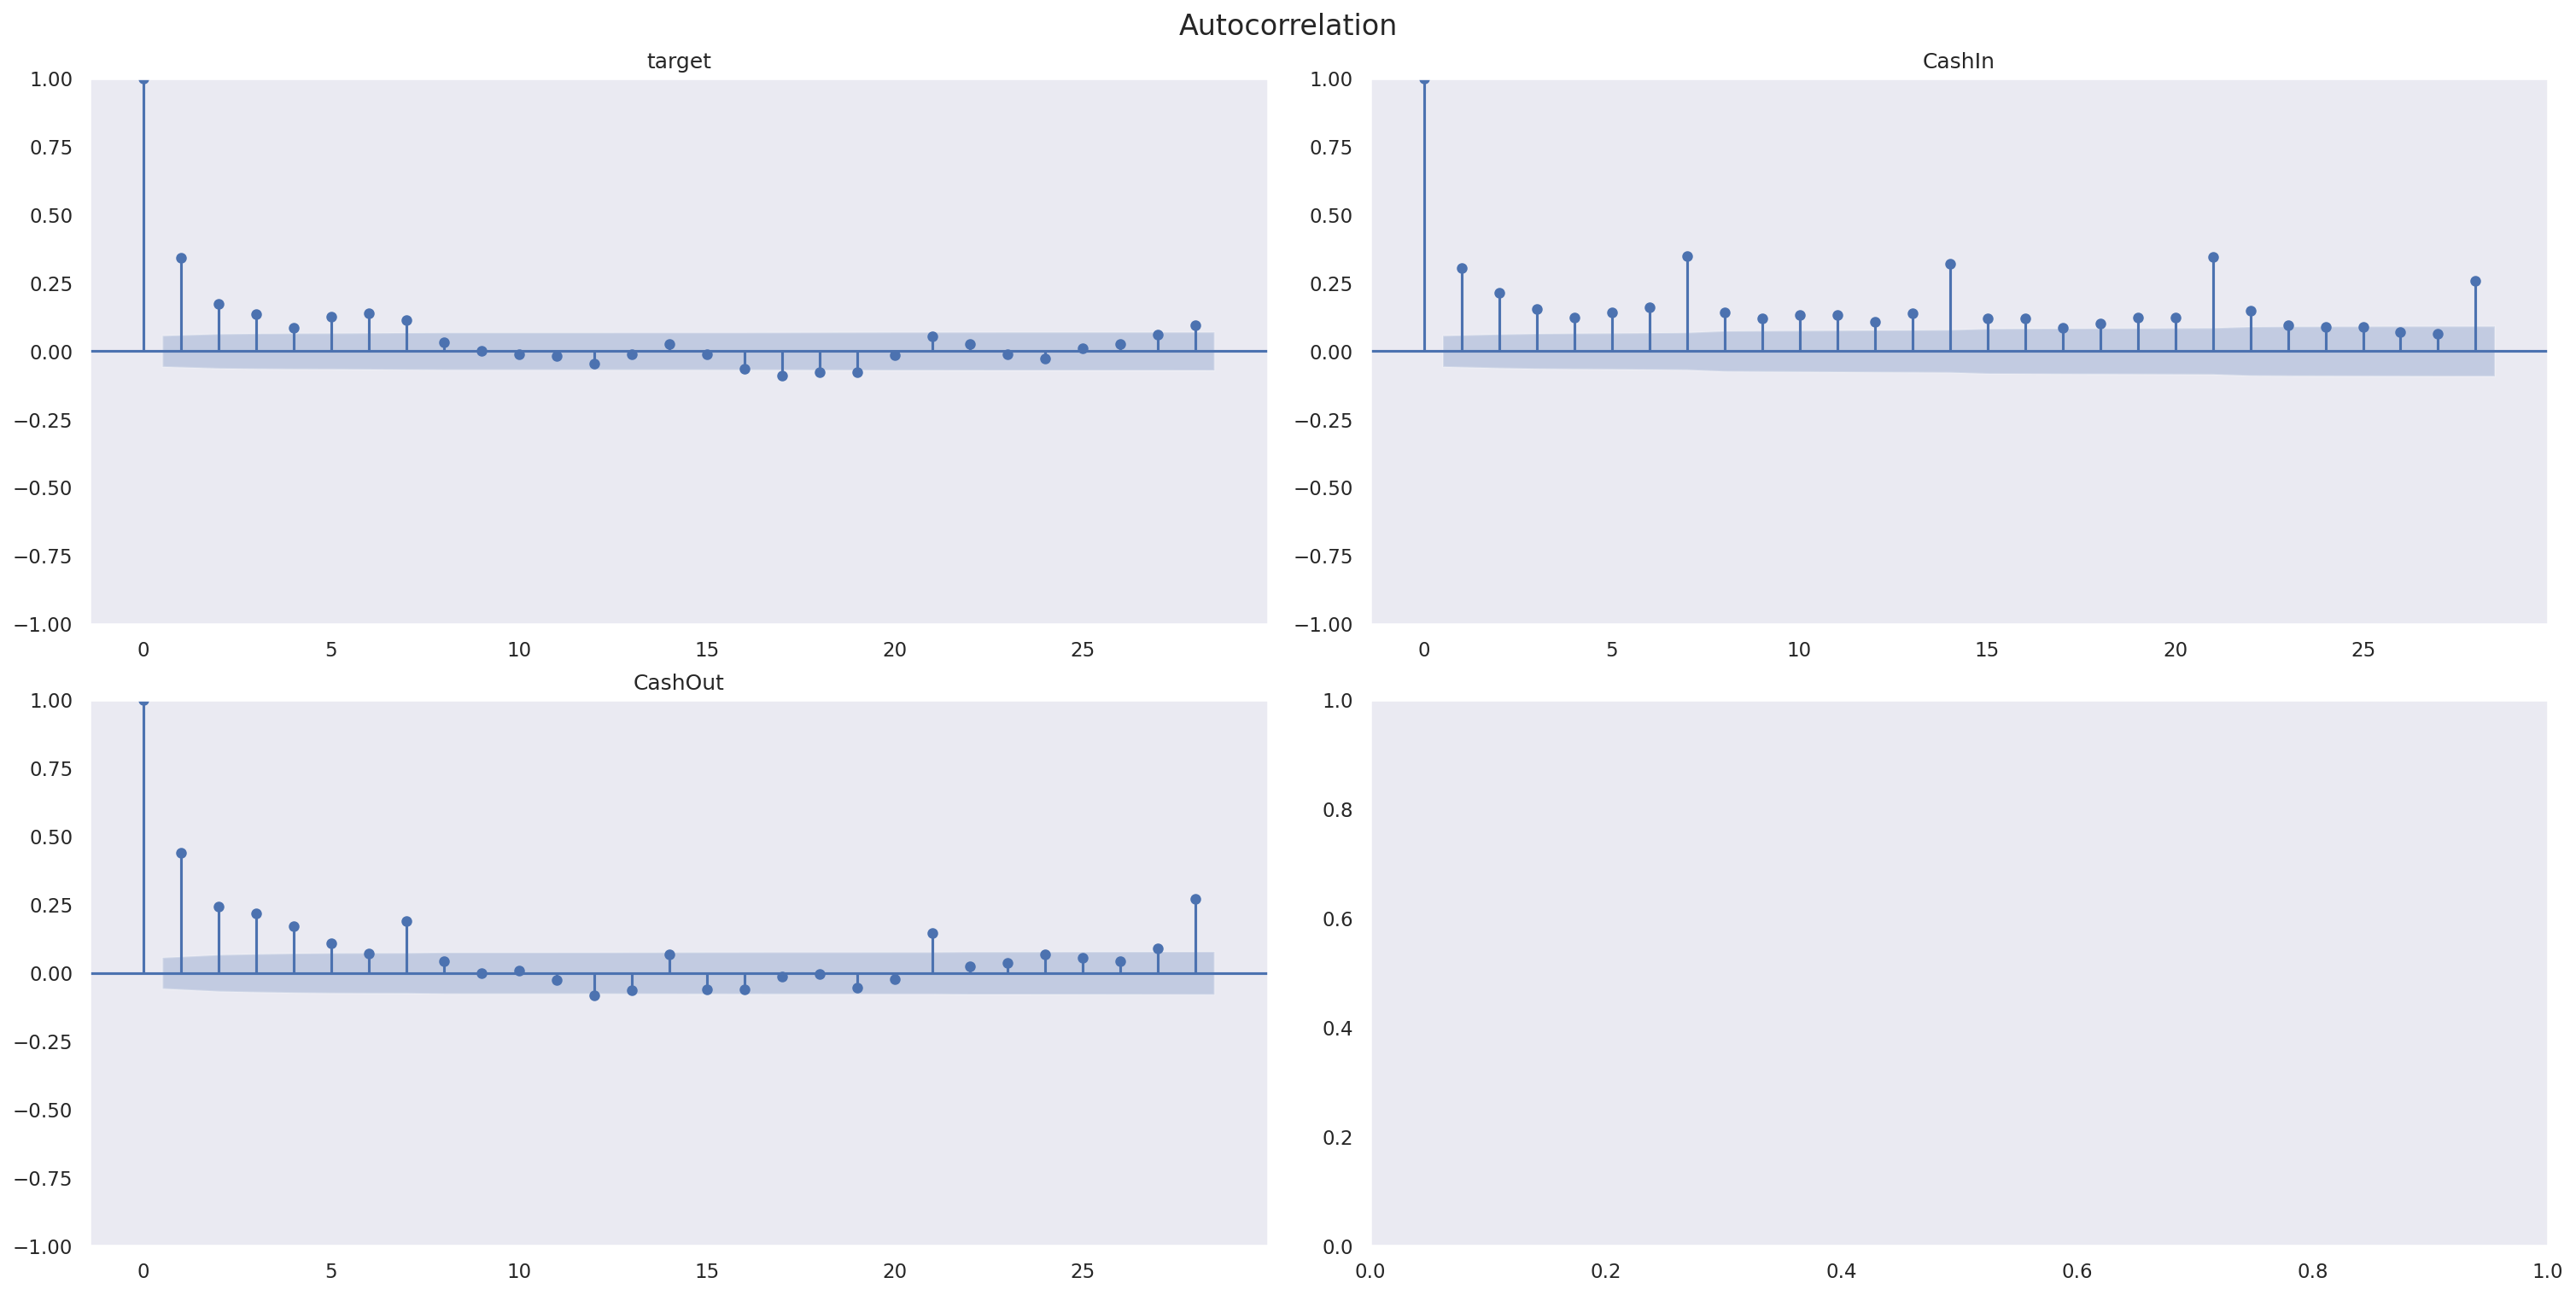

In [21]:
sample_acf_plot(ts, segments=["target", "CashIn", "CashOut"], lags=28)

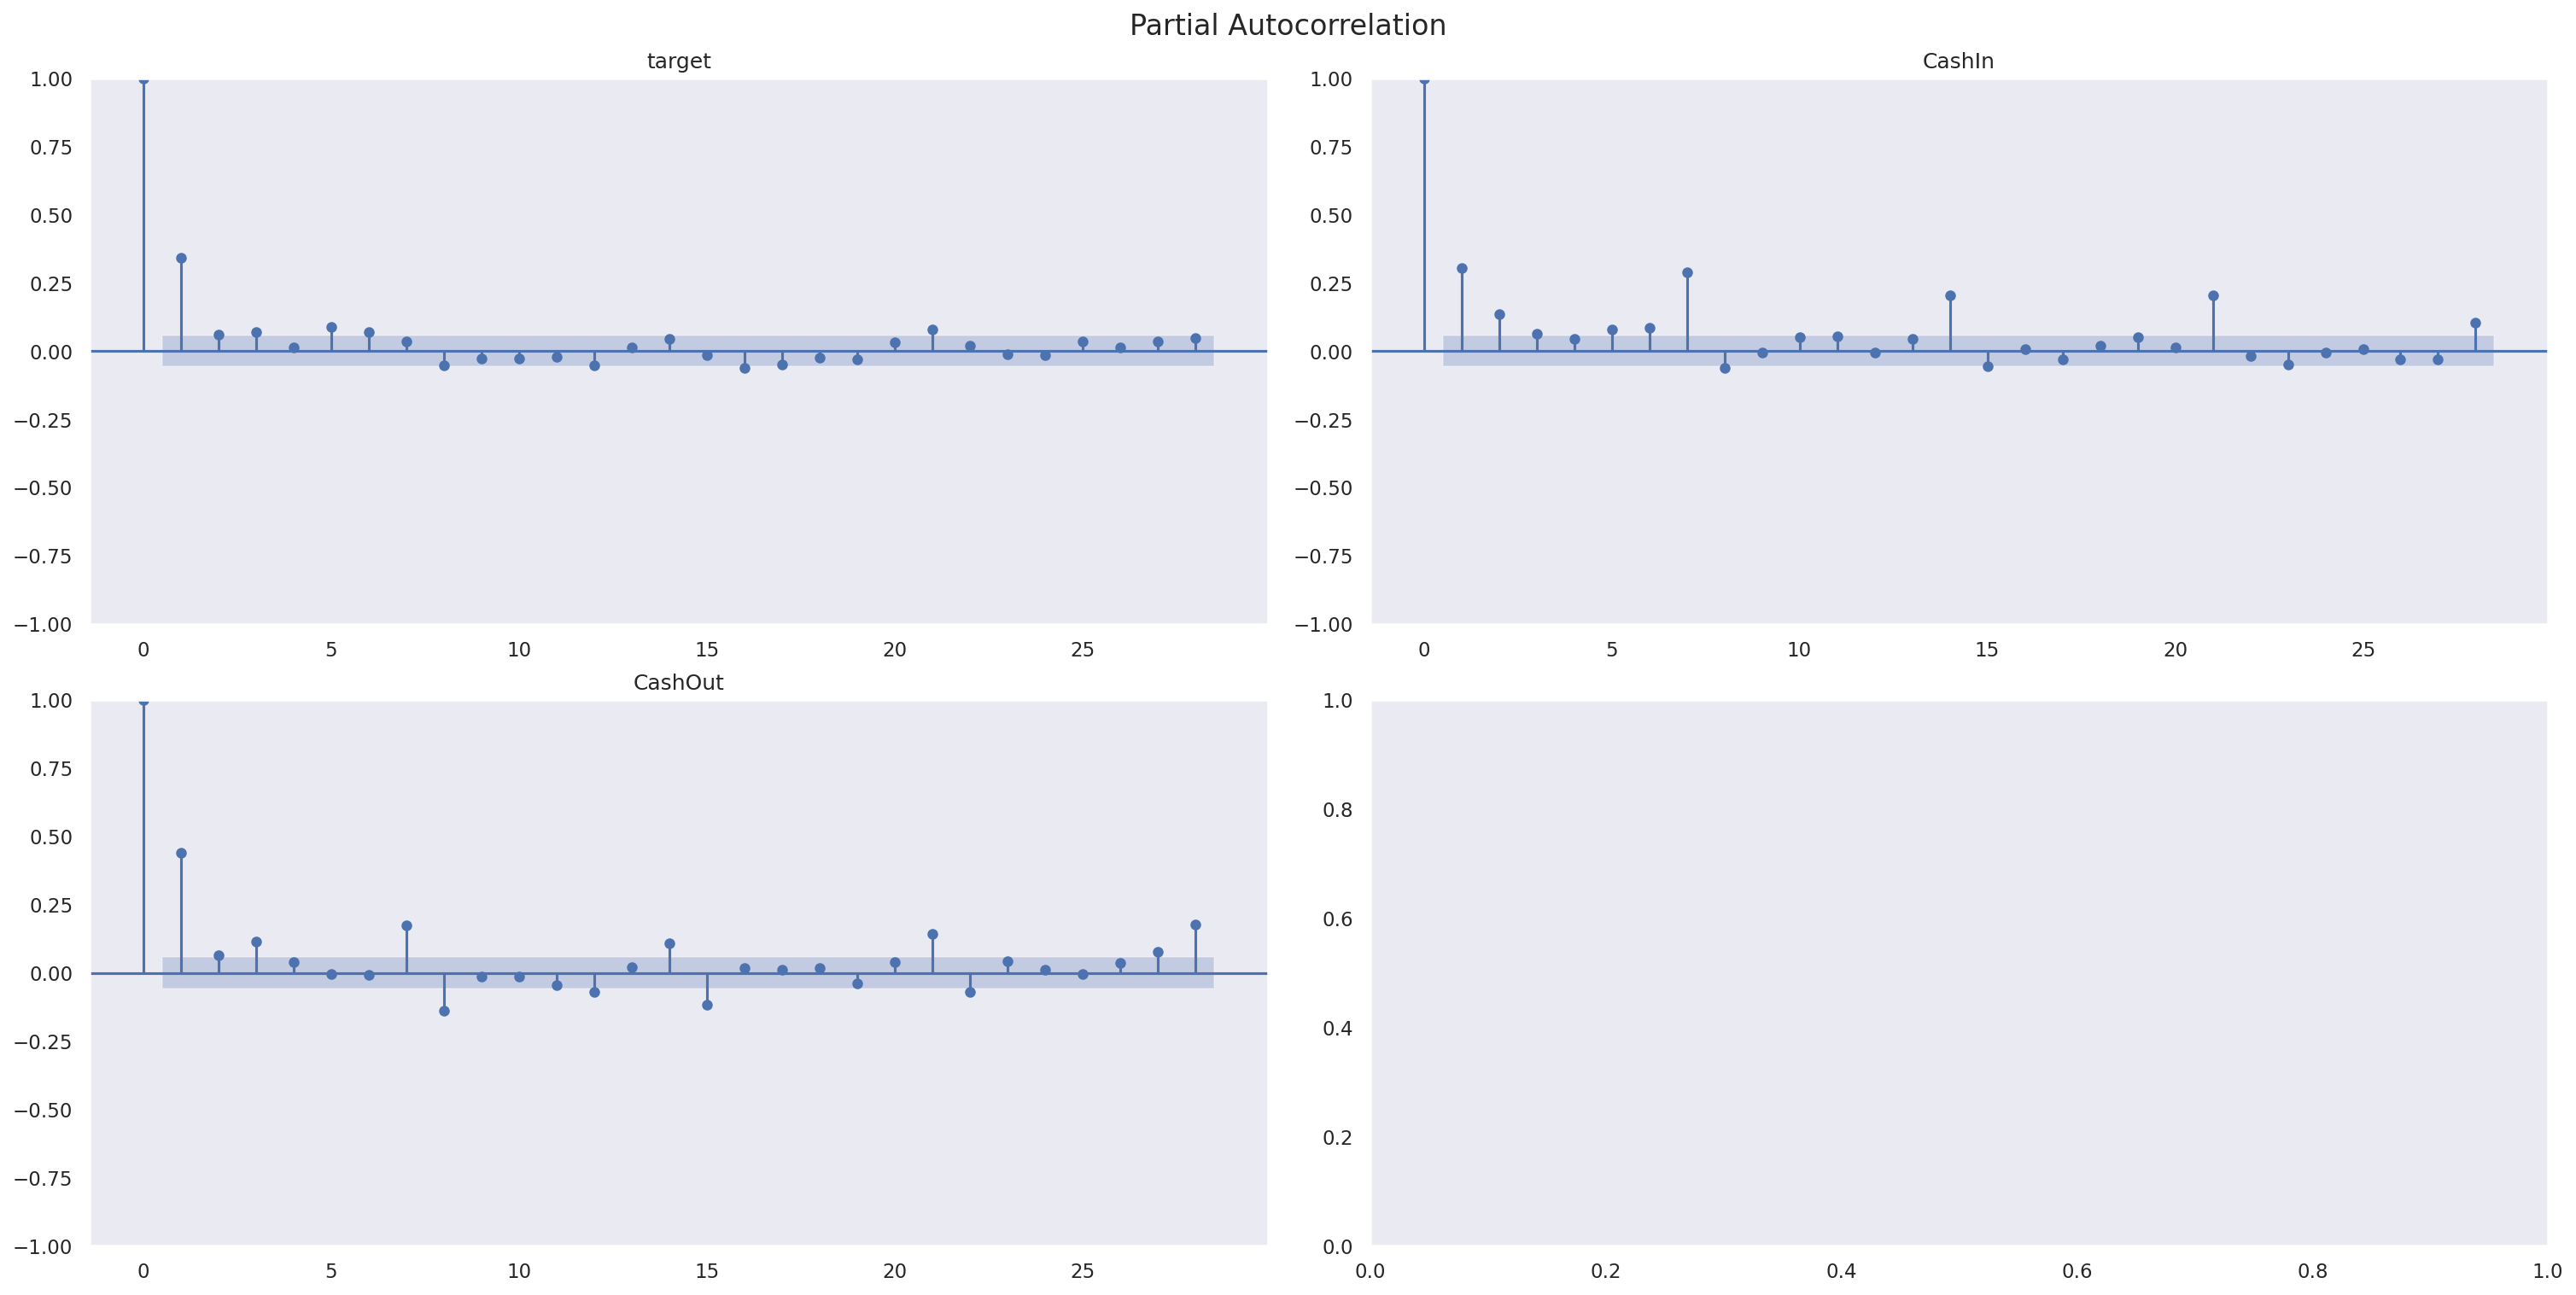

In [22]:
sample_pacf_plot(ts, segments=["target", "CashIn", "CashOut"], lags=28)

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

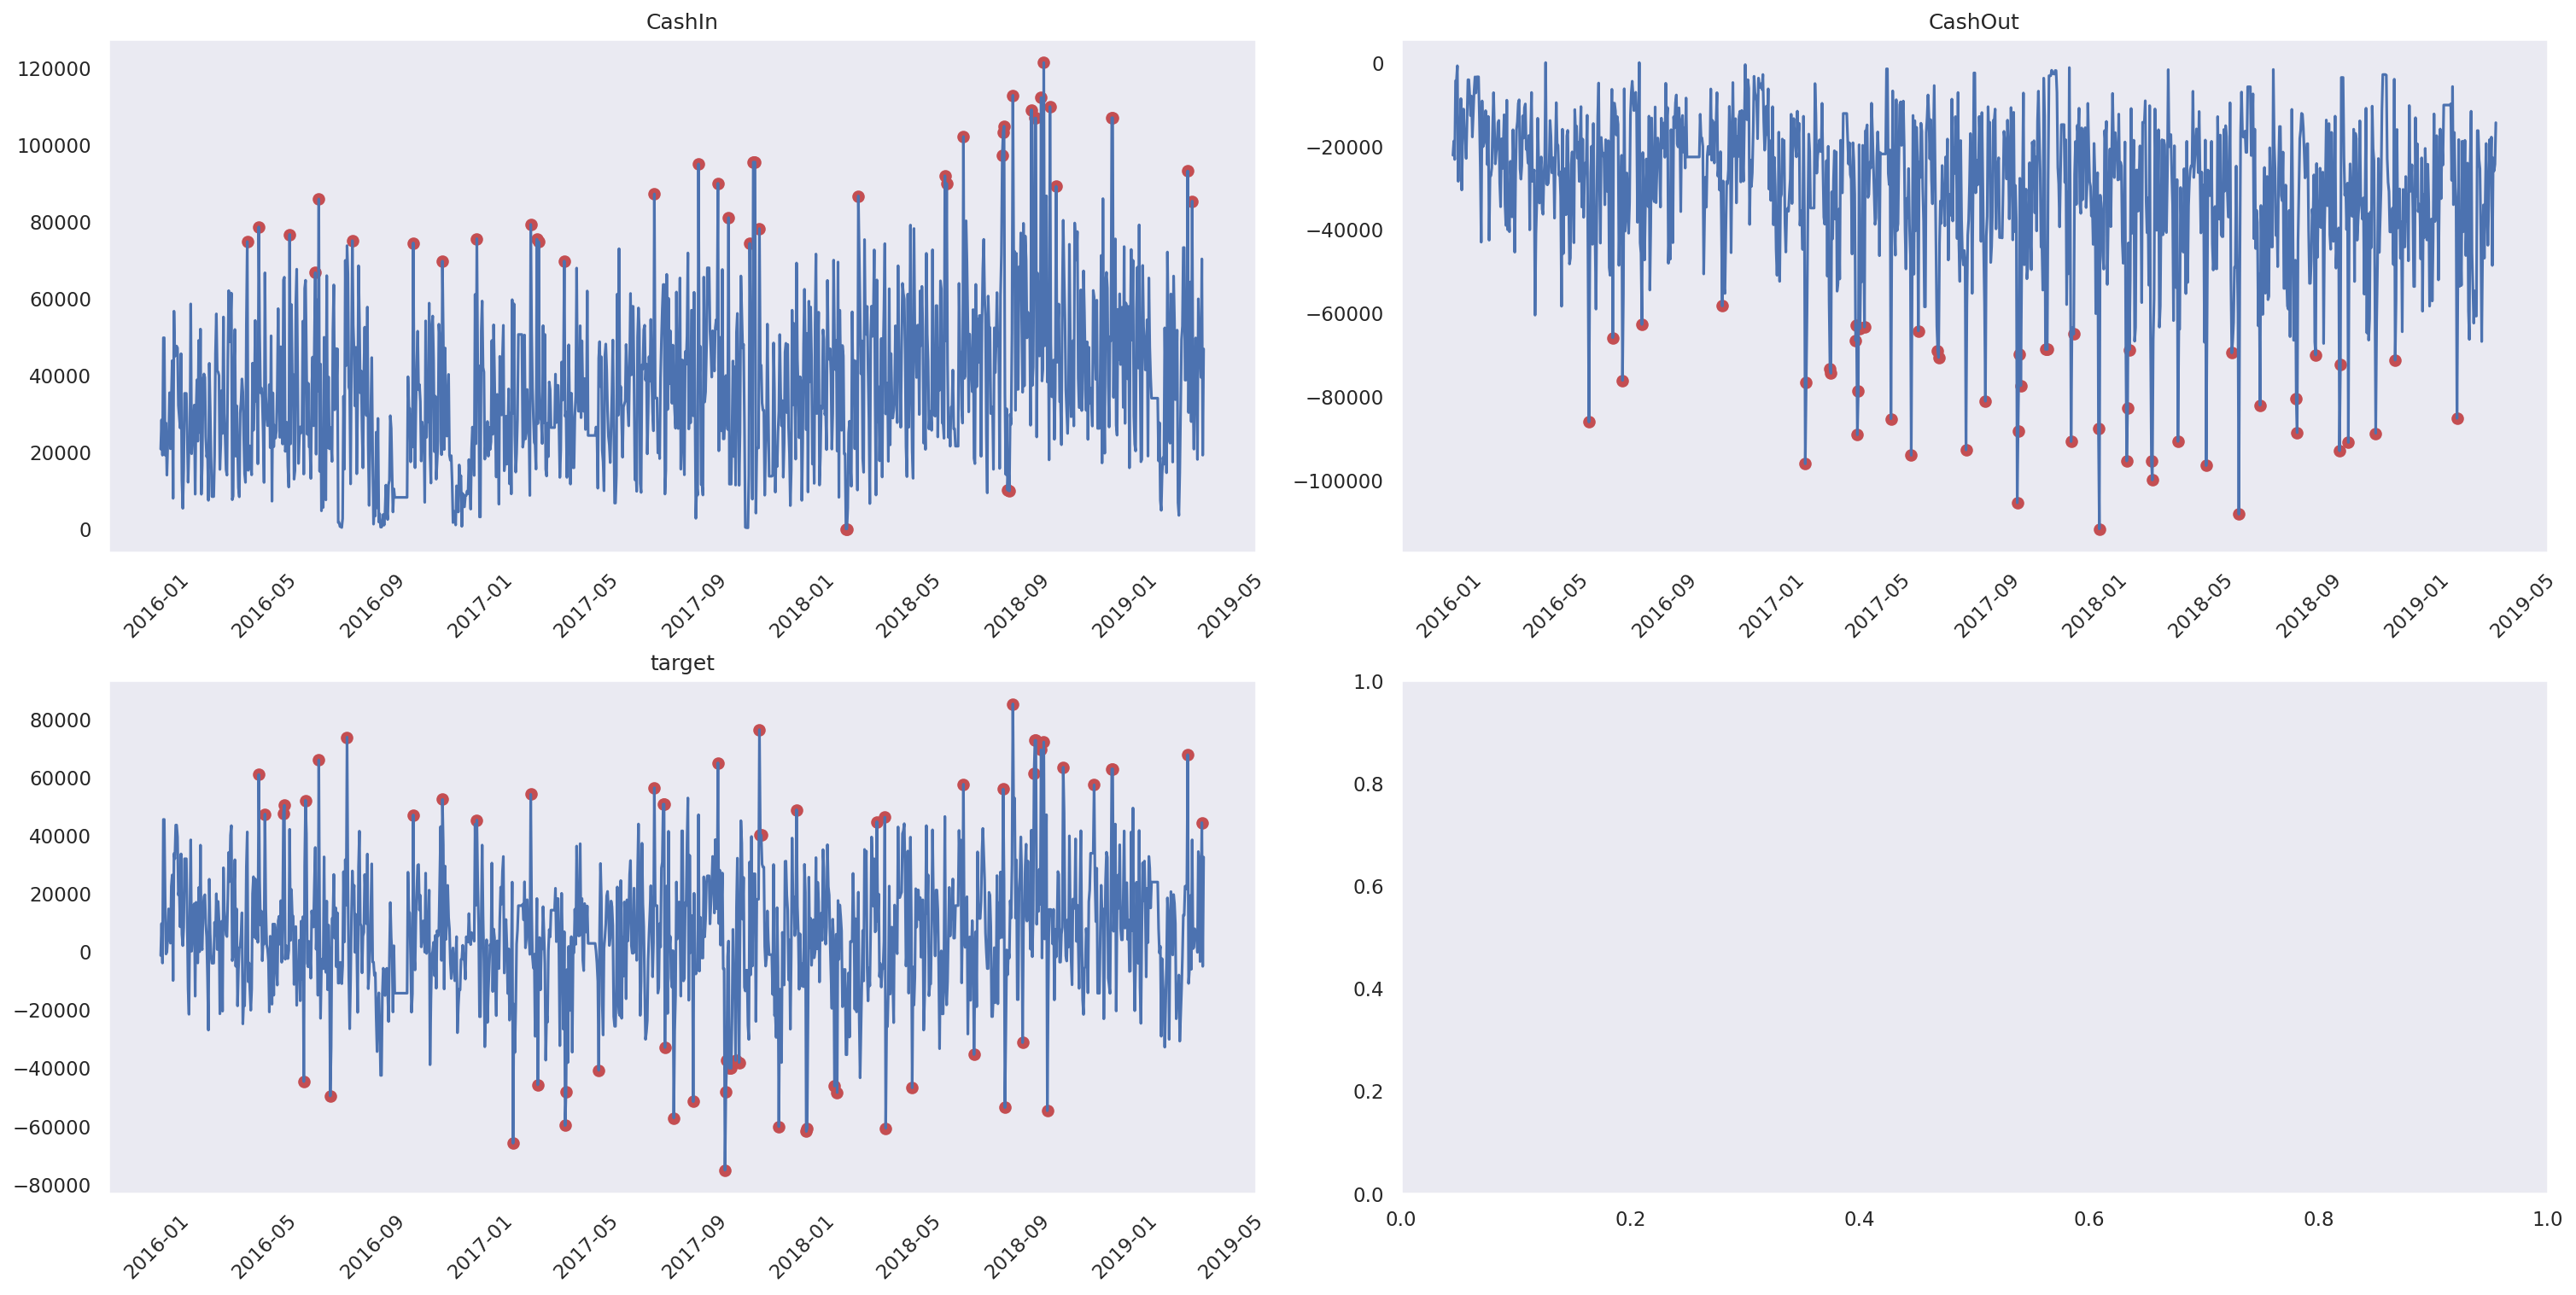

In [23]:
anomaly_dict = get_anomalies_density(ts, window_size=45, distance_coef=1.9, n_neighbors=25)
plot_anomalies(ts, anomaly_dict)

In [24]:
from etna.models import SARIMAXModel

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15184D+01    |proj g|=  7.76885D-02


 This problem is unconstrained.



At iterate    5    f=  1.15119D+01    |proj g|=  7.52767D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   7.528D-06   1.151D+01
  F =   11.511889759689319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13145D+01    |proj g|=  7.52810D-02

At iterate    5    f=  1.13073D+01    |proj g|=  7.56859D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.041D-05   1.131D+01
  F =   11.307310837057125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.15395D+01    |proj g|=  9.68186D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   9.682D-06   1.154D+01
  F =   11.539458631850913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


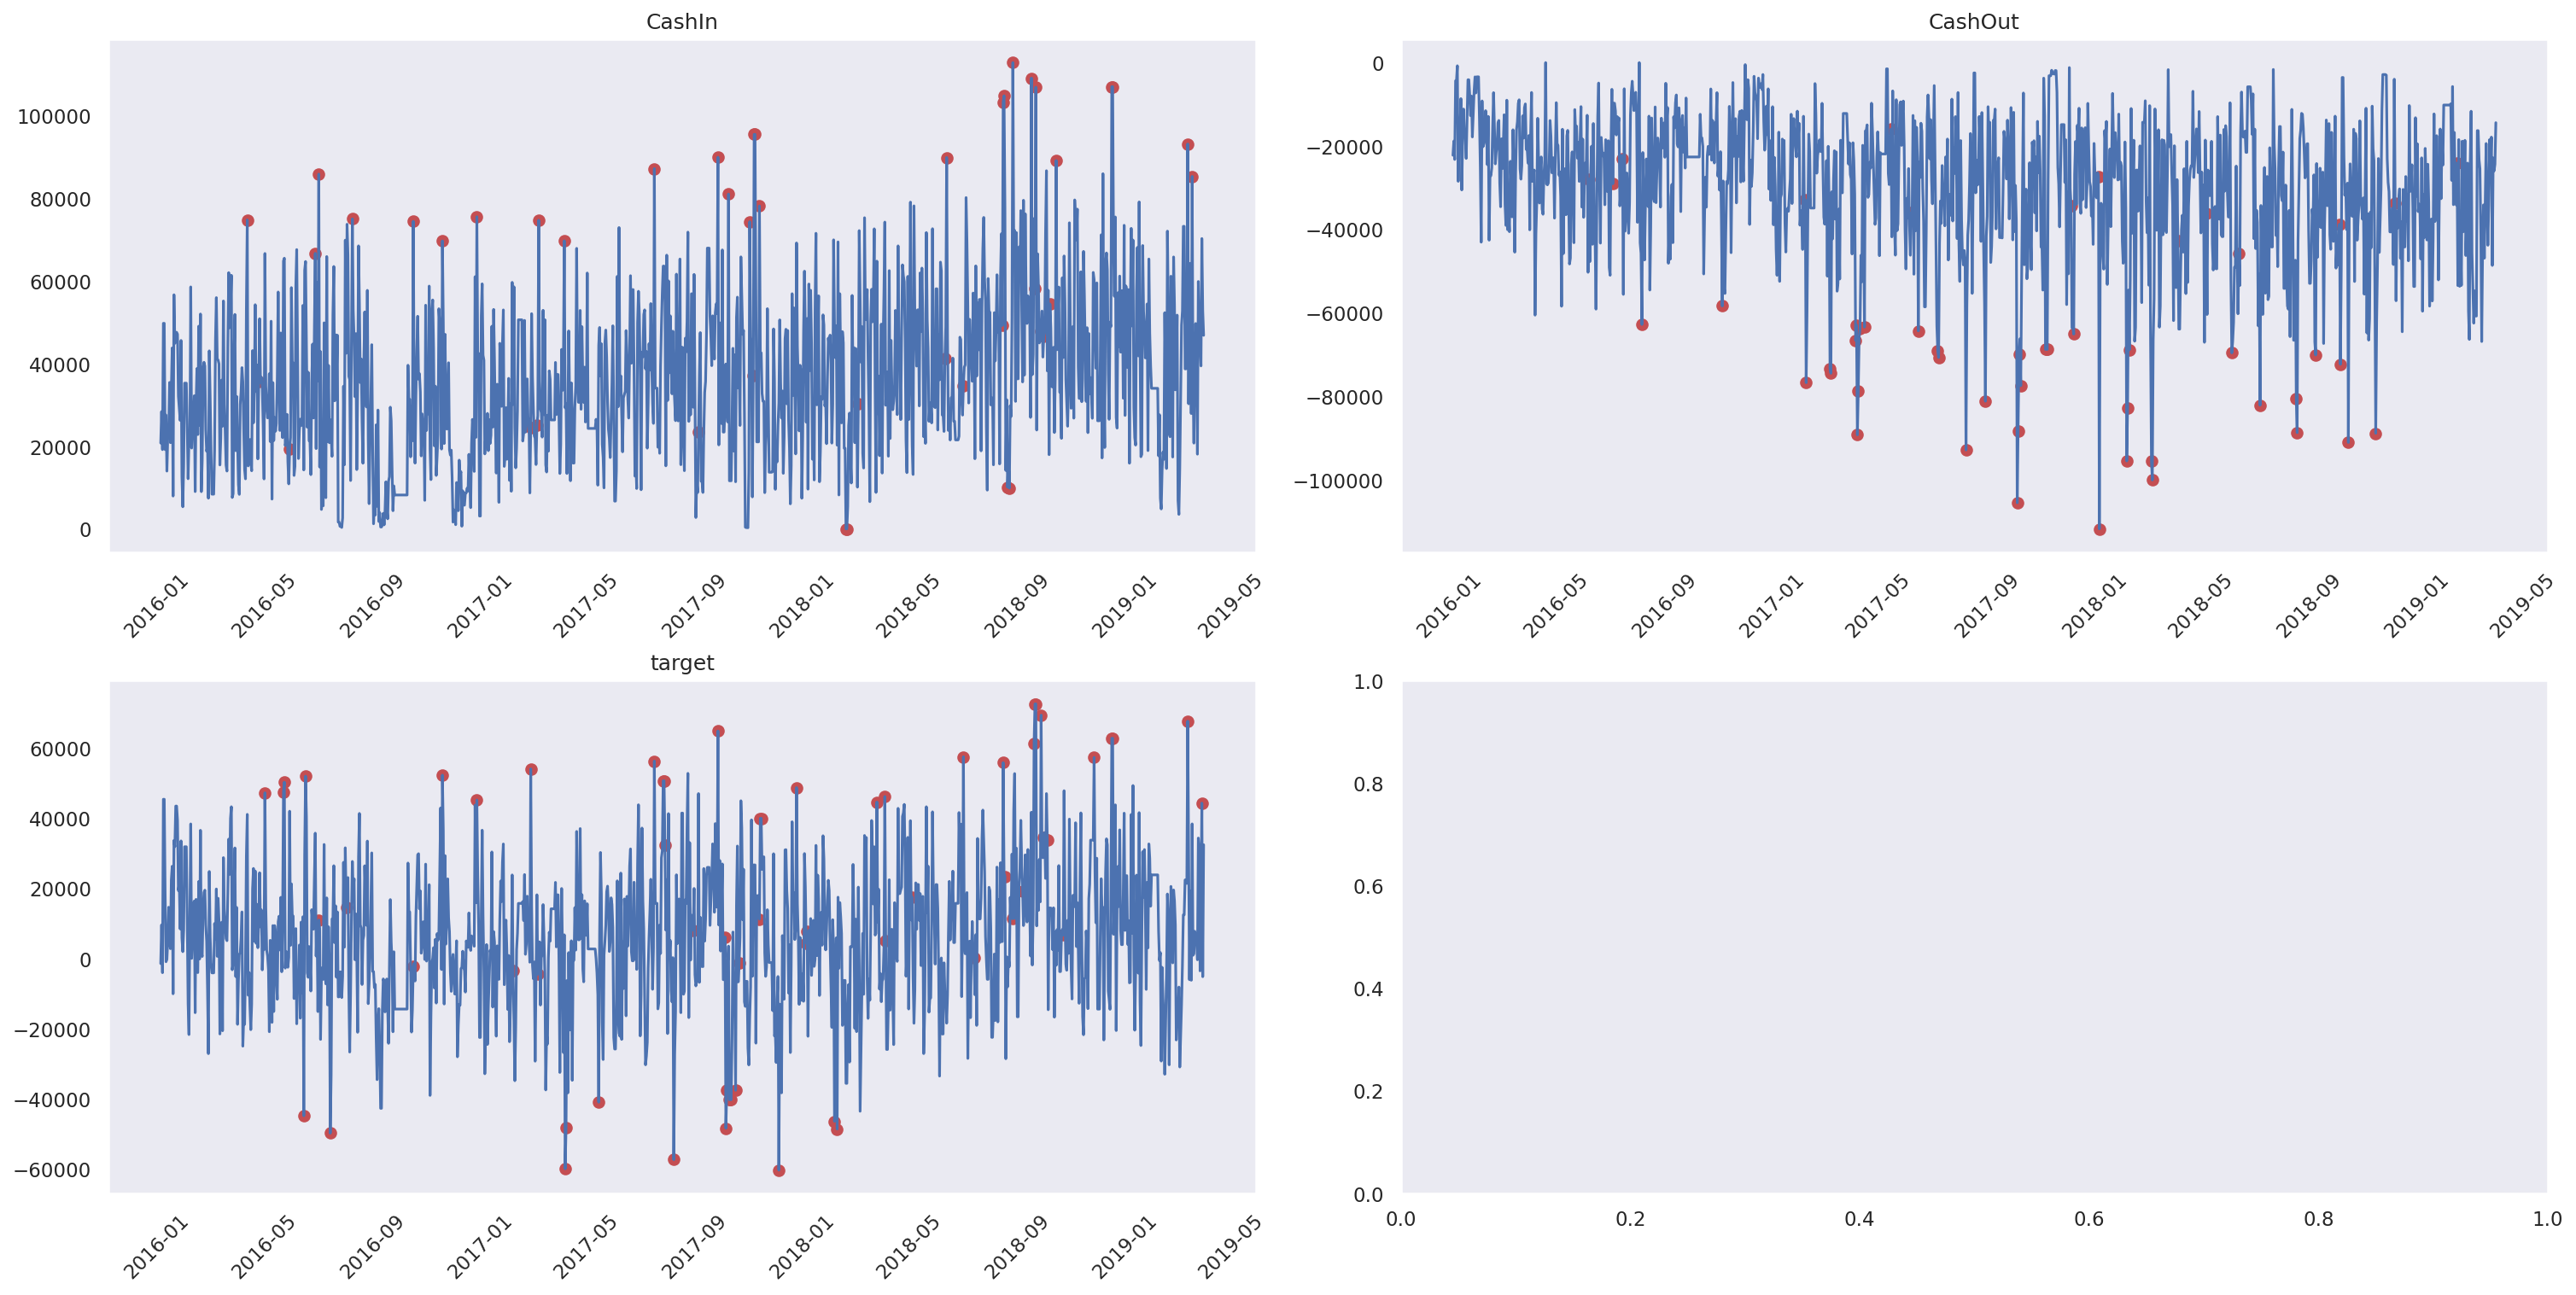

In [25]:
# Impute outliers with NaNs
#outliers_remover = MedianOutliersTransform(in_column="target")
outliers_remover = PredictionIntervalOutliersTransform(in_column="target", model=SARIMAXModel)
#outliers_remover = DensityOutliersTransform(in_column="target")
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=5
)
ts.fit_transform([outliers_remover, outliers_imputer])
#ts.plot()
plot_anomalies(ts, anomaly_dict)

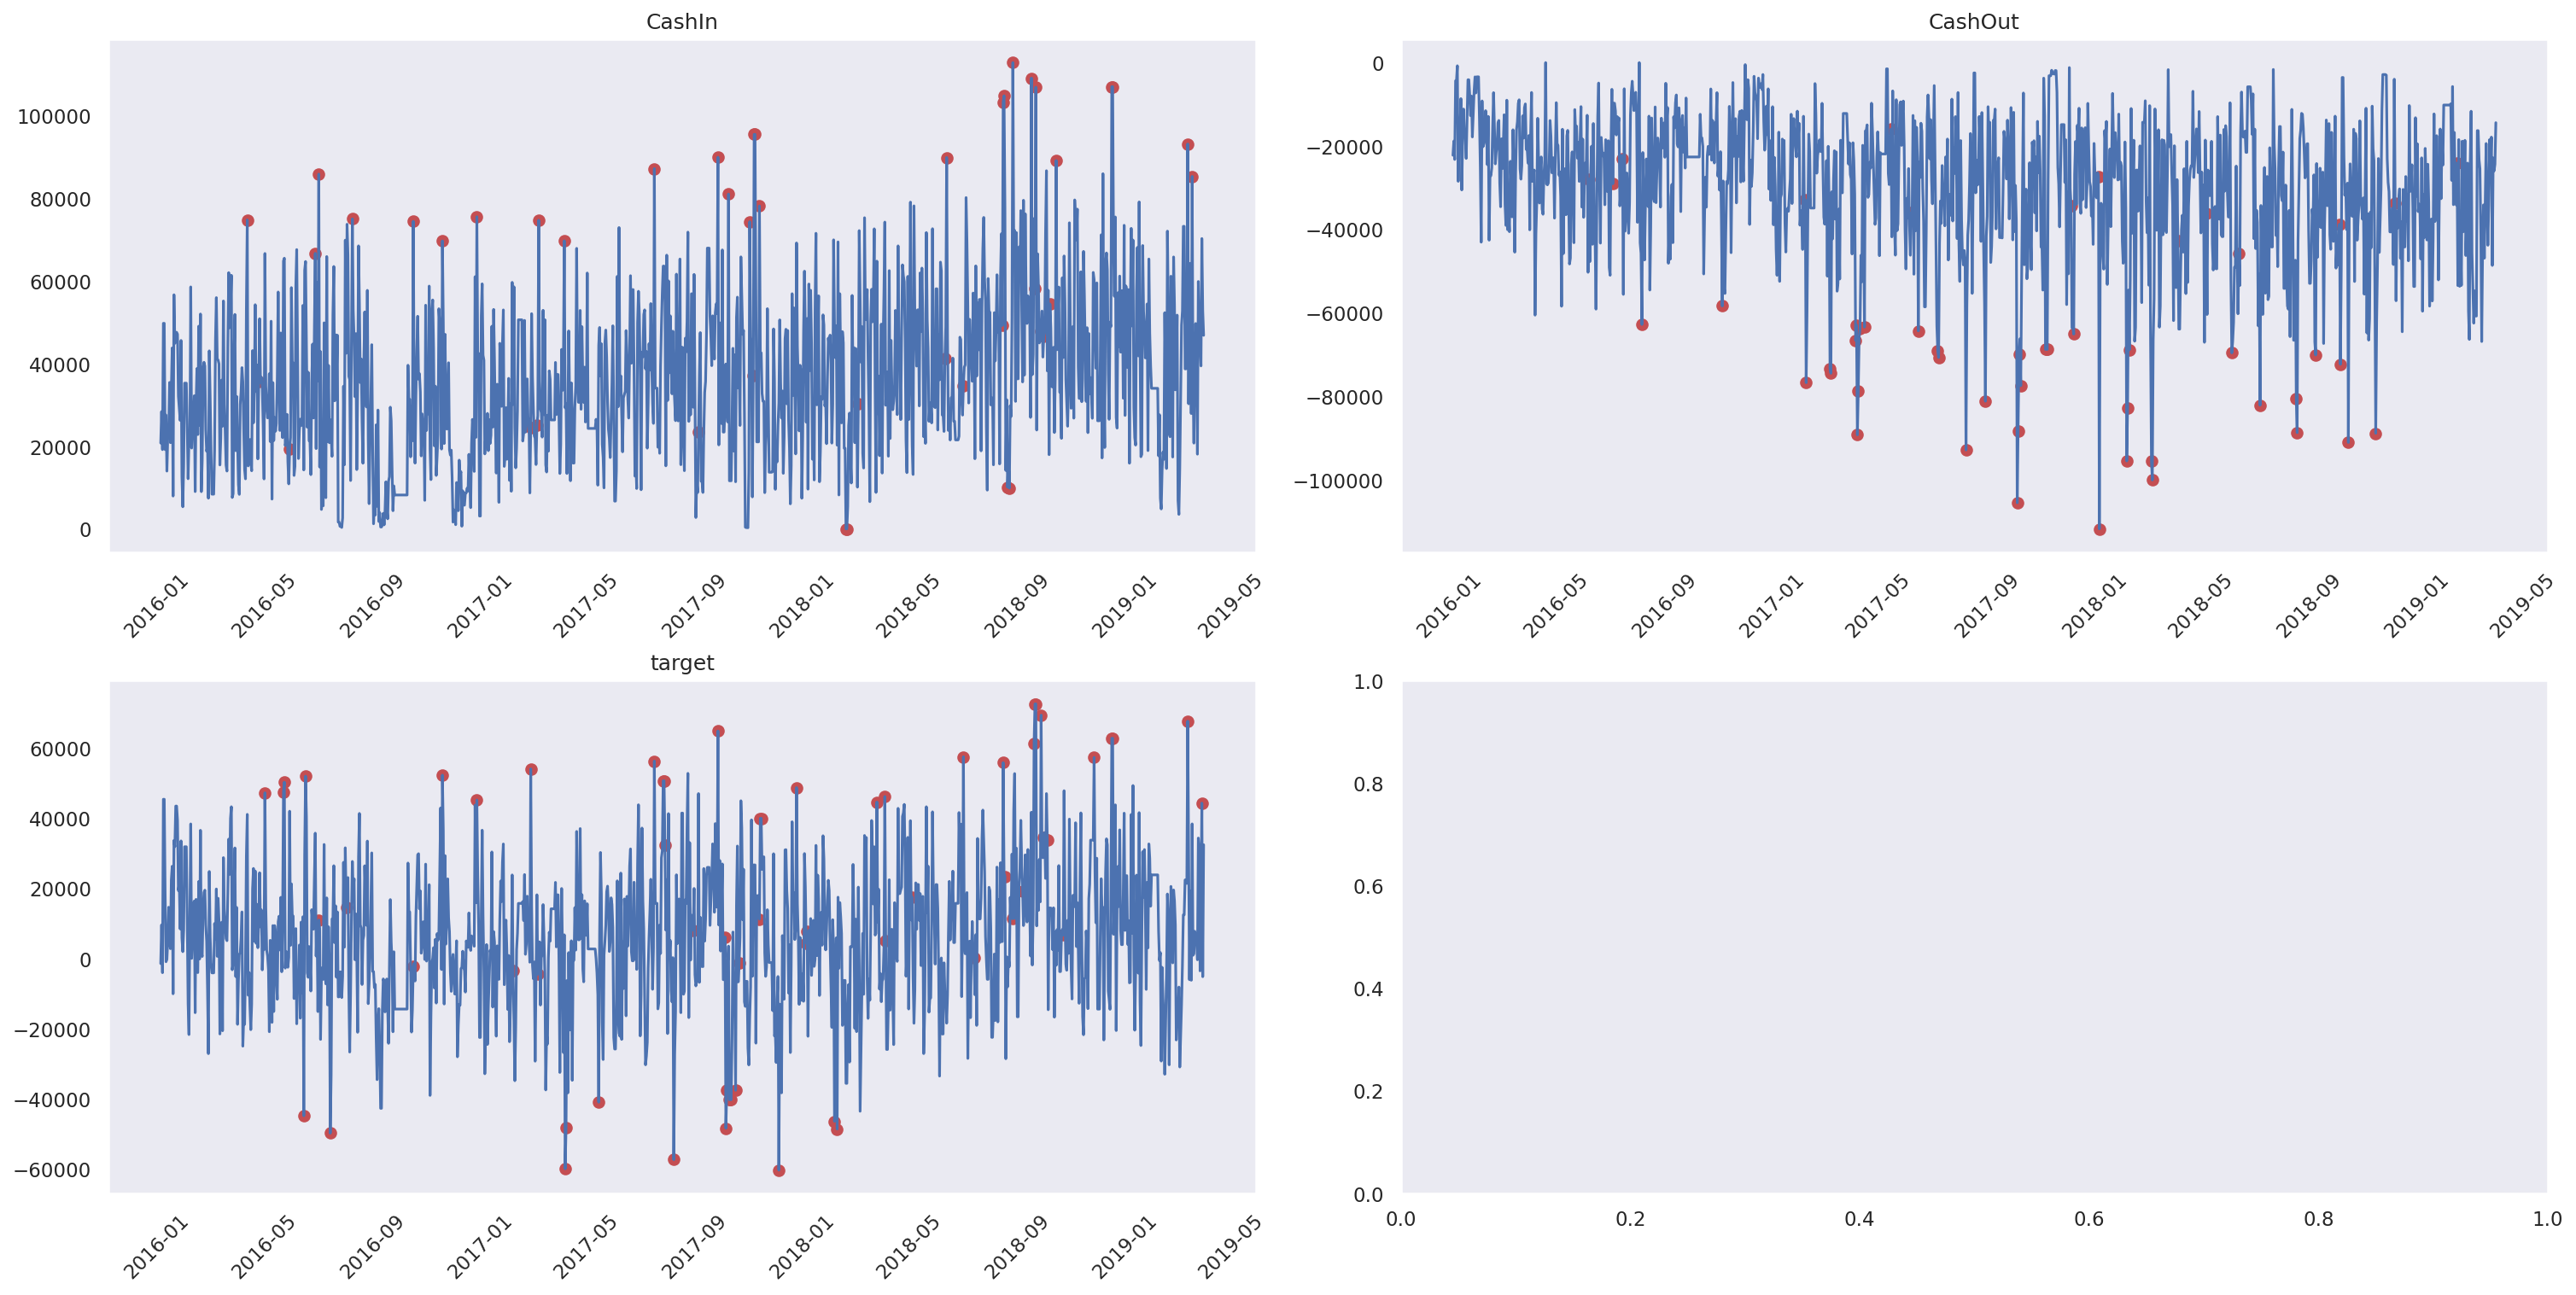

In [26]:
plot_anomalies(ts, anomaly_dict)

Аутлайеры есть, я их убрал, но он что-то еще находит. Больше выглядит как баг, так как значения где-то в середине, которые он выделяет навряд ли аутлаеры.

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [27]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [28]:
HORIZON = 5

In [29]:
NFOLDS=5
pipeline = Pipeline(model=ProphetModel())
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=NFOLDS, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
10:00:33 - cmdstanpy - INFO - Chain [1] start processing
10:00:33 - cmdstanpy - INFO - Chain [1] done processing
10:00:34 - cmdstanpy - INFO - Chain [1] start processing
10:00:34 - cmdstanpy - INFO - Chain [1] done processing
10:00:34 - cmdstanpy - INFO - Chain [1] start processing
10:00:34 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
10:00:39 - cmdstanpy - INFO - Chain [1] start processing
10:00:39 - cmdstanpy - INFO - Chain [1] done processing
10:00:39 - cmdstanpy - INFO - Chain [1] start processing
10:00:40 - cmdstanpy - INFO - Chain [1] done processing
10:00:40 - cmdstanpy - INFO - Chain [1] start processing
10:00:40 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
10:00:45 - cmdstanpy - INFO - Chain [1] start processing
10:00:45 - cmdstanpy - I

segment           MAE       SMAPE
0   CashIn  13438.565626   27.889422
1  CashOut  14249.460216   46.562681
2   target  18918.182420  144.921446

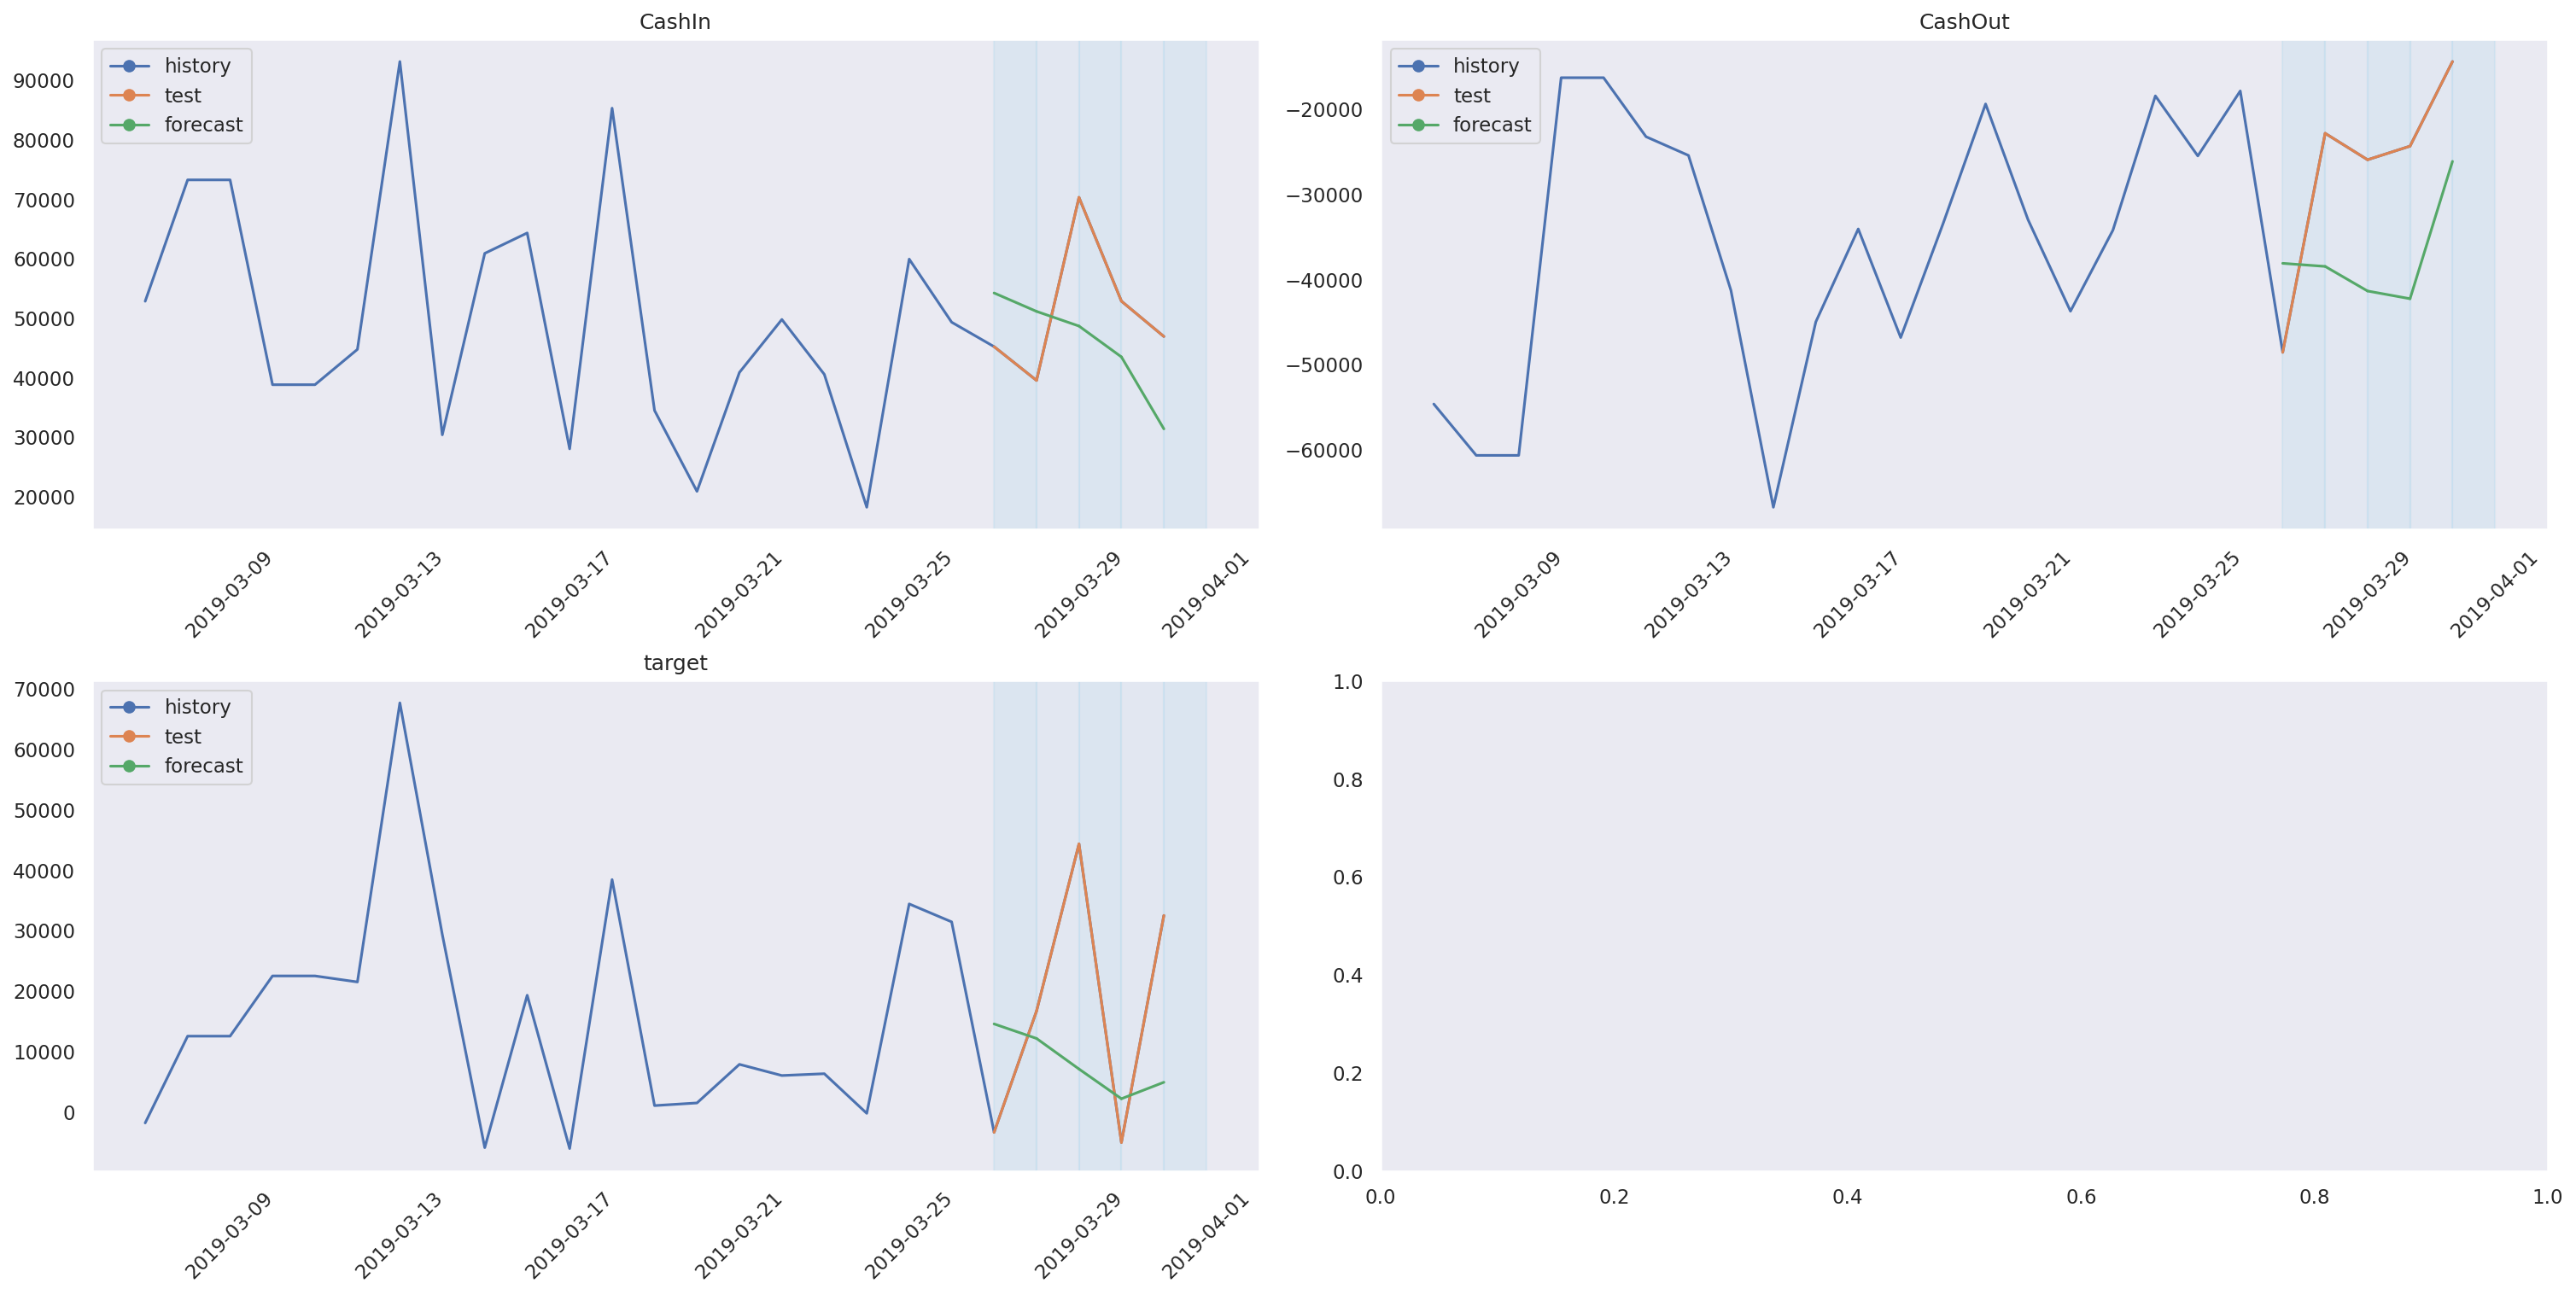

In [30]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=20)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Не очень понял, что тут хотят от меня... Ну, лучше предсказывать отдельно CashIn и CashOut, а не target сразу, судя по метрикам - наверное это просили.

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [32]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [33]:
reason_segments = ["CashIn", "CashOut"]

In [34]:
df[reason_segments].head()

CashIn  CashOut
4  20840.0 -22200.0
5  28460.0 -18810.0
6  19250.0 -23210.0
7  49770.0  -4350.0
8      NaN      NaN

In [35]:
df.rename(columns={"Date": "timestamp"}, inplace=True)

In [36]:
df.set_index("timestamp", inplace=True)

In [37]:
hierarchical_df = []
periods = len(df)
for segment_name in reason_segments:
    segment = df[segment_name]
    segment_slice = pd.DataFrame(
        {"timestamp": segment.index, "target": segment.values, "segment": [segment_name] * periods}
    )
    hierarchical_df.append(segment_slice)

hierarchical_df = pd.concat(hierarchical_df, axis=0)
hierarchical_df.head()

timestamp   target segment
0  1/5/2016  20840.0  CashIn
1  1/6/2016  28460.0  CashIn
2  1/7/2016  19250.0  CashIn
3  1/8/2016  49770.0  CashIn
4  1/9/2016      NaN  CashIn

In [38]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

In [39]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"total": ["CashIn", "CashOut"]}, level_names=["total", "reason"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['CashIn', 'CashOut']}, level_names = ['total', 'reason'], )

In [40]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)
hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MASE и MAE на кросс-валидации.

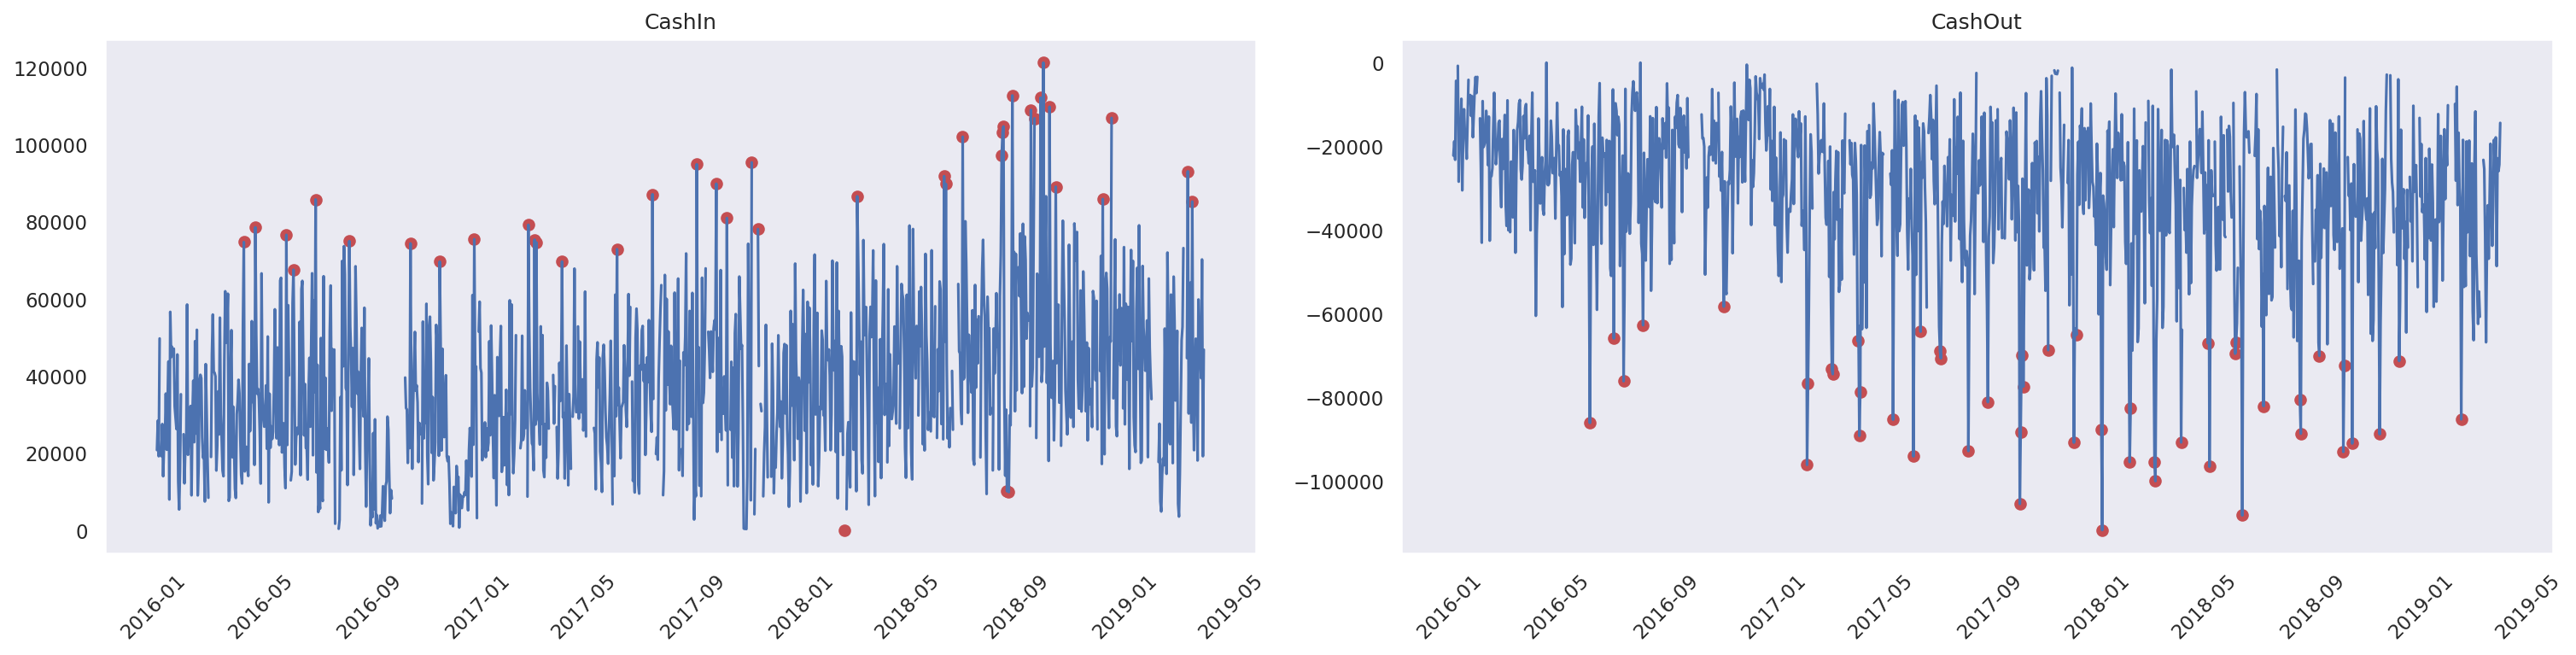

In [41]:
anomaly_dict = get_anomalies_density(hierarchical_ts, window_size=45, distance_coef=1.9, n_neighbors=25)
plot_anomalies(hierarchical_ts, anomaly_dict)

10:01:07 - cmdstanpy - INFO - Chain [1] start processing
10:01:07 - cmdstanpy - INFO - Chain [1] done processing
10:01:07 - cmdstanpy - INFO - Chain [1] start processing
10:01:07 - cmdstanpy - INFO - Chain [1] done processing


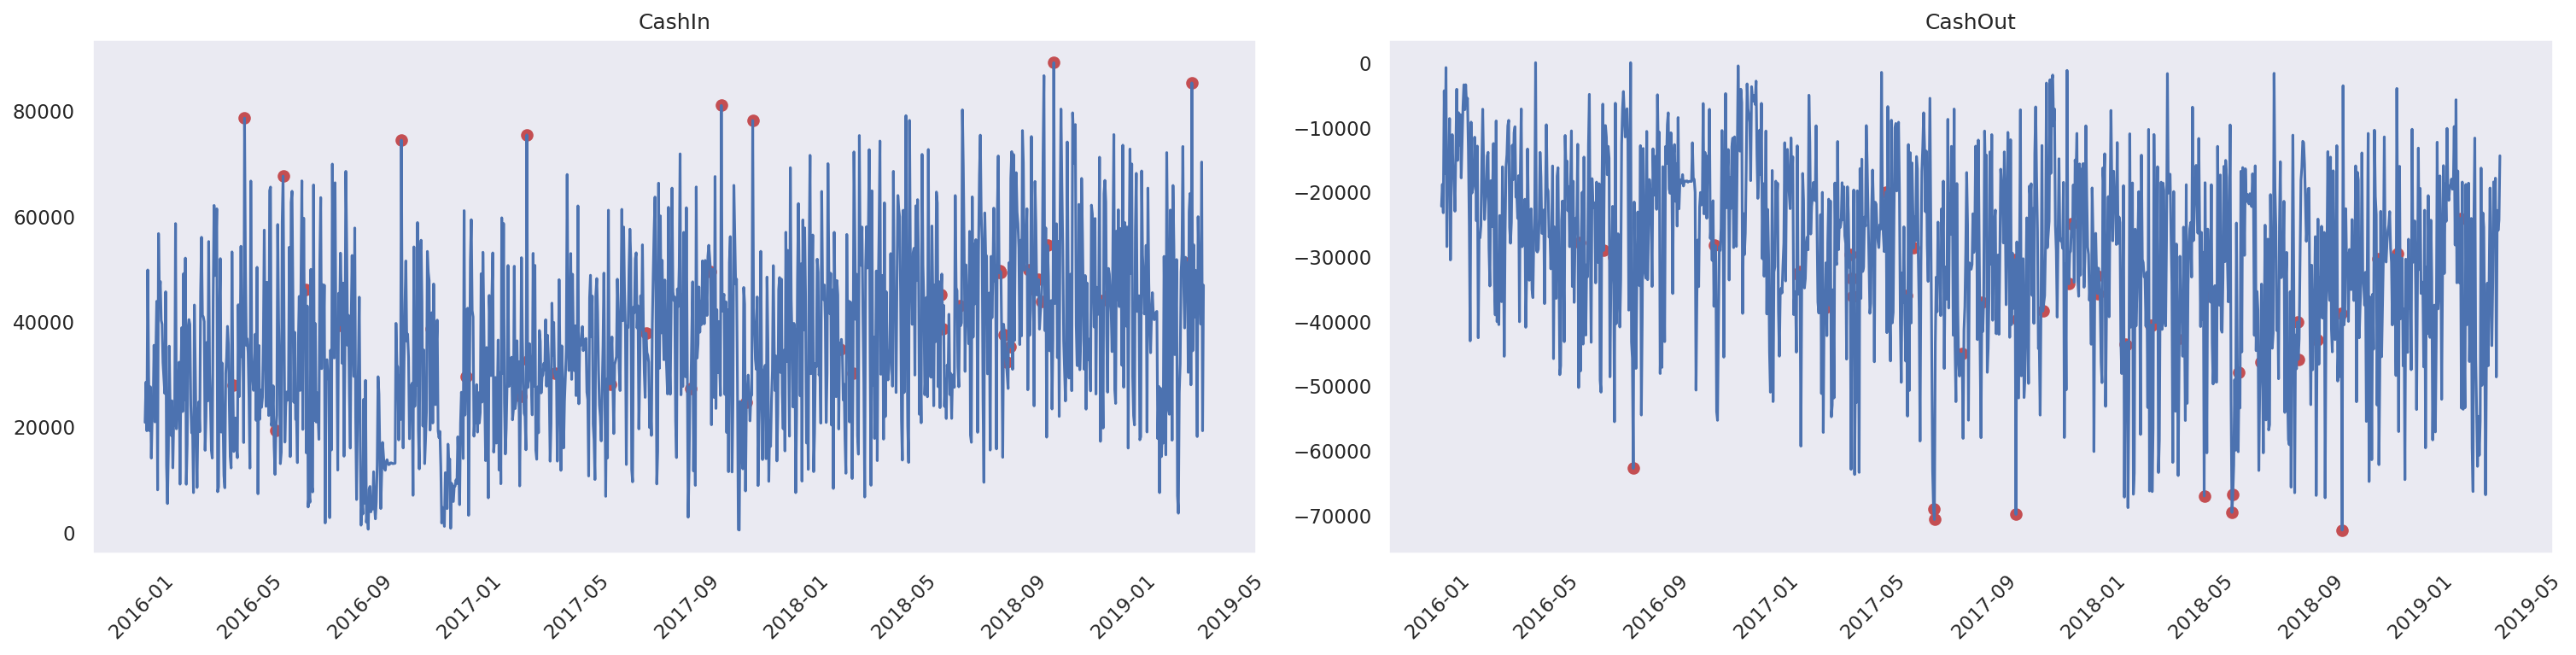

In [42]:
# Impute outliers with NaNs
#outliers_remover = MedianOutliersTransform(in_column="target")
outliers_remover = PredictionIntervalOutliersTransform(in_column="target", model=ProphetModel)
#outliers_remover = DensityOutliersTransform(in_column="target")
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=5
)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
#ts.plot()
plot_anomalies(hierarchical_ts, anomaly_dict)

In [43]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="reason")

In [44]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [45]:
NFOLDS=40
pipeline = HierarchicalPipeline(model=ProphetModel(), reconciliator=reconciliator)
metrics, forecast, _ = pipeline.backtest(
    ts=hierarchical_ts, metrics=[MAE(), SMAPE()], n_folds=NFOLDS, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
10:01:33 - cmdstanpy - INFO - Chain [1] start processing
10:01:33 - cmdstanpy - INFO - Chain [1] done processing
10:01:33 - cmdstanpy - INFO - Chain [1] start processing
10:01:33 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
10:01:37 - cmdstanpy - INFO - Chain [1] start processing
10:01:37 - cmdstanpy - INFO - Chain [1] done processing
10:01:37 - cmdstanpy - INFO - Chain [1] start processing
10:01:37 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
1

segment           MAE      SMAPE
0   total  15265.535494  133.39965

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [46]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [47]:
HORIZON=5

In [48]:
ts

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09  49770.0  -4350.0  45420.0
...             ...      ...      ...
2019-03-27  45160.0 -48600.0  -3440.0
2019-03-28  39480.0 -22840.0  16640.0
2019-03-29  70260.0 -25950.0  44310.0
2019-03-30  52810.0 -24350.0  -5100.0
2019-03-31  46870.0 -14400.0  32470.0

[1182 rows x 3 columns]

In [49]:
lags = LagTransform(in_column="target", lags=list(range(5, 8, 1)))
stl = STLTransform(in_column="target", period=7)

Автокорреляции я строил выше(вроде во втором задании). Период в 7 дней обусловлен тем, что снятие и пополнение происходит примерно раз в неделю.

In [50]:
NFOLDS=40
pipeline = Pipeline(model=CatBoostModelPerSegment(), transforms=[lags, stl], horizon=HORIZON)
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=NFOLDS, aggregate_metrics=True, n_jobs=-1
)
metrics

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | 

segment           MAE       SMAPE
0   CashIn  18770.348879   43.812522
1  CashOut  15895.335826   54.436092
2   target  21591.623197  129.377827

In [51]:
NFOLDS=40
pipeline = Pipeline(model=AutoARIMAModel(), transforms=[stl], horizon=HORIZON)
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=NFOLDS, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | 

segment           MAE       SMAPE
0   CashIn  17992.824186   40.897724
1  CashOut  14678.702869   47.140268
2   target  20296.123263  125.114507

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [52]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

выше и так везде прямой применял, так что тут просто копирую тот, что был с кэтбустом

In [53]:
NFOLDS=40
HORIZON=5
pipeline = Pipeline(model=CatBoostModelPerSegment(), transforms=[lags, stl], horizon=HORIZON)
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=NFOLDS, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | 

segment           MAE       SMAPE
0   CashIn  18770.348879   43.812522
1  CashOut  15895.335826   54.436092
2   target  21591.623197  129.377827

In [54]:
model = CatBoostModelPerSegment()
NUMBER_OF_LAGS=7
HORIZON=6
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.0s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   30.1s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.4s finished


In [55]:
metrics_recursive_df

segment       SMAPE           MAE  fold_number
0   CashIn   79.567006  20832.310593            0
0   CashIn   38.779423  21909.993369            1
0   CashIn   39.710697  19595.729576            2
0   CashIn   31.144864  10861.977527            3
0   CashIn   25.005365  11267.384010            4
1  CashOut   56.342700  20418.373942            0
1  CashOut   46.464775  15006.709293            1
1  CashOut   40.633442  15828.515718            2
1  CashOut   34.646738  11039.839617            3
1  CashOut   57.674981  17636.819941            4
2   target  189.070056  19486.185972            0
2   target   62.624124  13809.024058            1
2   target  123.043050  17772.245317            2
2   target  140.976926  17343.379466            3
2   target  128.674314  19495.774338            4

In [56]:
direct = DirectEnsemble(pipelines=[pipeline, autoregressivepipeline])

In [57]:
metrics, forecast, _ = direct.backtest(
    ts=ts, metrics=[SMAPE(), MAE()]
)
metrics

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done

segment       SMAPE           MAE  fold_number
0   CashIn   83.552866  22893.709419            0
0   CashIn   35.857231  19845.381423            1
0   CashIn   35.665148  21286.391776            2
0   CashIn   57.246719  28409.087338            3
0   CashIn   46.945866  18225.433875            4
1  CashOut   47.948550  18538.084356            0
1  CashOut   46.612312  17172.765405            1
1  CashOut   77.798943  22188.232925            2
1  CashOut   50.652697  19630.413160            3
1  CashOut   49.365031  15606.318675            4
2   target  139.752028  16663.642396            0
2   target  156.360558  22370.778271            1
2   target  112.352908  25358.018789            2
2   target  149.231538  20927.532312            3
2   target  147.381135  23026.261397            4

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [58]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [64]:
HORIZON=5

In [65]:
autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=1
)
pipeline = Pipeline(model=CatBoostModelPerSegment(), transforms=[lags, stl], horizon=HORIZON)

In [66]:
pipelines=[pipeline, autoregressivepipeline]

In [67]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 9], n_jobs=4)

In [68]:
N_FOLDS=40

In [71]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), SMAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=4,
)[0].iloc[:, 1:]
voting_ensamble_metrics

[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  

MAE       SMAPE
0  15999.913050   36.775236
1  13317.540955   42.269581
2  16911.922418  114.633736

In [85]:
pipeline2 = Pipeline(model=AutoARIMAModel(), transforms=[stl], horizon=HORIZON)

In [86]:
pipelines2 = [pipeline, pipeline2]

In [87]:
stack_ensemble = StackingEnsemble(pipelines=pipelines2, n_folds=10)

Эта библа нааастолько крутая (говно полное), что один и тот же код, который работает для одного ансамбля, может не заработать для другого просто потому, что там, видимо, писали все кое-как, и никакой общей структуры нет. Поэтому нужно пересобрать ts, изменив название target на что-то еще, иначе оно не заработает и выкинет ошибку "KeyError: 'target'".

In [136]:
df2 = pd.read_csv('atm_daily_cash.csv')
df2 = df2[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

In [137]:
df2['CashOut'] = -df2['CashOut']
df2['target'] = df2['CashIn'] + df2['CashOut']

In [138]:
df2 = df2.rename(columns={"target": "main"})

In [139]:
dfcopy2 = pd.melt(df2.copy(deep=True), id_vars=['Date'], value_vars=['main', 'CashIn', 'CashOut'], var_name='segment', value_name='target')
dfcopy2.rename(columns={'Date': 'timestamp'}, inplace=True)

In [140]:
dfcopy2 = TSDataset.to_dataset(dfcopy2)
ts2 = TSDataset(dfcopy2, freq="D")
ts2.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
main          2016-01-05    2019-03-31    1182          110


In [144]:
imputer = TimeSeriesImputerTransform(in_column='target', strategy="forward_fill")
ts2.fit_transform([imputer])

In [145]:
ts2.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0
main          2016-01-05    2019-03-31    1182            0


In [146]:
ts2

segment      CashIn  CashOut     main
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09  49770.0  -4350.0  45420.0
...             ...      ...      ...
2019-03-27  45160.0 -48600.0  -3440.0
2019-03-28  39480.0 -22840.0  16640.0
2019-03-29  70260.0 -25950.0  44310.0
2019-03-30  19250.0 -24350.0  -5100.0
2019-03-31  46870.0 -14400.0  32470.0

[1182 rows x 3 columns]

In [147]:
stack_ensemble_metrics = stack_ensemble.backtest(
    ts=ts2,
    metrics=[MAE(), SMAPE()],
    n_folds=10,
    aggregate_metrics=True
)[0].iloc[:, 1:]
stack_ensemble_metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of

MAE       SMAPE
0  19573.029754   57.583811
1  14777.447354   44.922021
2  20515.482534  152.073950

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [60]:
#YOUR CODE HERE#